We generate the longitudinal time-to-event data to demonstrate our proposed algorithm following the simulation study in [Seaman and Keogh (2024)](https://onlinelibrary.wiley.com/doi/epdf/10.1002/bimj.70010) or [Line *et al* (2025)](https://arxiv.org/pdf/2502.07991).


Variables considered:

- 2 baseline variables $X_1$, $X_2$.

- 2 time-varying covariates $L1$, $L2$.


- $E_k$: exposure to treatment at follow-up $k$ (max $k=6$).

- $T$: time-to-event

    - $Y_k = I(T > k)$: survival status
observed at each visit.


- At baseline:

  - $X_1\sim Exponential(2.0)$

  - $X_2\sim Bernoulli(0.7)$

  - $L1_0\sim Gamma(k=1+0.5X_1+0.5X_2,\theta=1)$

  - $L2_0\sim Bernoulli\{expit(-0.2+0.5X_1+0.5X_2)\}$

- Treatment assignment is infludenced by $X_1,X_2, L1_k, L2_k$ as:

  - $E_k\sim Bernoulli\{expit(-1.5+0.5X_1+0.5X_2+0.5L1_k+0.5L2_k)\}$

- Subsequent visits $(k>0)$:

  - $L1_k\sim Gamma(k=1+0.5X_1+0.5X_2+0.1L1_{k-1}+0.5E_{k-1},\theta=1)$

  - $L2_k\sim Bernoulli\{expit(-0.2+0.5X_1+0.5X_2+L2_{k-1}+0.6E_{k-1})\}$

- A Cox MSM model is assumed, given by:
$$\lambda(t|do(\bar{E}_{t^*}),X_2)=\lambda_0\exp(\beta_EE_{t^*}+\beta_{X_2}X_2+\beta_{X_2E}X_2E_{t^*})$$
  - $\lambda_0$ is the time-constant baseline hazard (set as $\lambda_0=exp(-2)$)

  - $E_{t^*}$ is the treatment at the integer time immediately before time $t$ ($t^*=floor(t)$)

- Parameters:

  - $\beta_{X_2}=-0.5$

  - The values of $(\beta_E,\beta_{X_2E})$ vary for generating scenarios of different treatment strengths

    - A strong/large effect size: $(\beta_E,\beta_{X_2E})=(-0.5, 0.3)$.

    - A weak/small effect size: $(\beta_E,\beta_{X_2E})=(0.2,0.1)$

  - Given survival at follow-up time $k$, the survival time $T$ follows an exponential distribution with the hazard rate defined above:
  
  $$T-k|T>k\sim Exponential\{\lambda(t|do(\bar{E}_{t^*}),X_2)\}$$

    - If $T-k<1$ then $Y_{k+1}=1$ and 0 otherwise.

- The copulas are set that weave the dependence betweeen $L1,L2$ and $Y$:
  - The dependency between $L1_j$ and $Y_{k+1}$ for $j=0,1,2,\cdots,k$ are student $t$ with parameter $\rho_1$ and df=5;
  - Those for $L2_j$ and $Y_{k+1}$ (given $L1_k$) for $j=0,1,2,\cdots,k$ are Gaussian with correlation $\rho_2$.
- The values of $\rho_1$ and $\rho_2$ are varied to construct scenarios with different strengths of confounding.
  - High confounding: $(\rho_1,\rho_2)=(0.9,0.7)$.
  - Medium confounding: $(\rho_1,\rho_2)=(-0.5,0.4)$
  - Low confounding: $(\rho_1,\rho_2)=(-0.1,-0.2)$
- 6 scenarios of different effect size and counfounding levels with 3 sample sizes $n=\{1000,2000,5000\}$



 A simulation to estimate the bias of an estimator: `bias = np.mean(estimates - true_param)`.
 
 An MC SE of the bias: `mc_se_bias = np.std(estimates - true_param, ddof=1) / np.sqrt(n_sims)`

In [2]:
pip install torch -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import log_loss

In [4]:
####### Extract eligible data
def determine_eligibility(df: pd.DataFrame, obs_id: str, obs_time: str, outcome: str):
    def eligibility_group(outcome_series):
        outcome_list = outcome_series.tolist()
        if 1 in outcome_list:
            match_index = outcome_list.index(1)
            return [1] * (match_index + 1) + [0] * (len(outcome_list) - match_index - 1)
        else:
            return [1] * len(outcome_list)
    df = df.copy()
    df.sort_values(by=[f"{obs_id}", f"{obs_time}"], ascending=[True, True], inplace=True)
    df['is_eligible'] = df.groupby(f"{obs_id}")[f"{outcome}"].transform(lambda x: eligibility_group(x))
    print(f"\n     An 'is_eligible' variable is included to identify observations for modeling '{outcome}'.")
    print(f"     Of {len(df)} observations, {sum(df['is_eligible']==1)} are eligible.")
    return df

def subset_eligible_data(df: pd.DataFrame, obs_id: str, obs_time: str, outcome: str):
    df1 = df.copy().sort_values([f"{obs_id}", f"{obs_time}"])
    df1 = determine_eligibility(df1, obs_id, obs_time, outcome)
    elig_df = df1[df1["is_eligible"] == 1].copy().reset_index(drop=True)
    print(f"\n     A dataframe containing only {len(elig_df)} eligible observations for IPW model is extracted.")
    del df1
    return elig_df

####### Spliting data
def split_data(df              : pd.DataFrame,
               obs_id          : str,
               outcome         : str,
               test_size       : float         = 0.2,
               is_val_required : bool          = False):
    if is_val_required:
      print(f"\n     Data to be split into sets of train {(1-test_size)*100}%, validation {(test_size/2)*100}% and test {(test_size/2)*100}%.")
    else:
      print(f"     Data to be split into sets of train {(1-test_size)*100}% and test {(test_size)*100}%.")
    end_times_df = df.groupby(f"{obs_id}").tail(1).reset_index(drop=True)
    subj_outcome_df = end_times_df[[f"{obs_id}", f"{outcome}"]].drop_duplicates()
    train_ids, temp_ids = train_test_split(subj_outcome_df[f"{obs_id}"],
                                           stratify=subj_outcome_df[f"{outcome}"],
                                           test_size=test_size, random_state=42
                                        )
    train_df = df[df[f"{obs_id}"].isin(train_ids)].copy().reset_index(drop=True)

    if is_val_required:
        temp_df = subj_outcome_df[subj_outcome_df[f"{obs_id}"].isin(temp_ids)].reset_index(drop=True)
        val_ids, test_ids = train_test_split(temp_df[f"{obs_id}"],
                                             stratify=temp_df[f"{outcome}"],
                                             test_size=0.5, random_state=42
                                            )
        val_df   = df[df[f"{obs_id}"].isin(val_ids)].copy().reset_index(drop=True)
        test_df  = df[df[f"{obs_id}"].isin(test_ids)].copy().reset_index(drop=True)

    else:
        val_df  = None
        test_df = df[df[f"{obs_id}"].isin(temp_ids)].copy().reset_index(drop=True)
    print("     Spliting completed.")
    return train_df, val_df, test_df

####### Tranform data
def transform_fixed_covs(obs_id    : str,
                         train_df  : pd.DataFrame,
                         val_df    : pd.DataFrame  = None,
                         test_df   : pd.DataFrame  = None,
                         quan_covs : list[str]     = None,
                         qual_covs : list[str]     = None
                        ):

    def select_inv_obs(df):
        return df.sort_values(by=f"{obs_id}").groupby(f"{obs_id}").first().reset_index()

    inv_cols = [f"{obs_id}"] + (quan_covs or []) + (qual_covs or [])

    if (qual_covs is not None) or (quan_covs is not None):
        train_inv_df = select_inv_obs(train_df)[inv_cols]
    else:
        raise Exception("No variable to be encoded or scaled.")

    val_inv_df = select_inv_obs(val_df)[inv_cols] if val_df is not None else None
    test_inv_df = select_inv_obs(test_df)[inv_cols] if test_df is not None else None
    print(f"        Time-invariant features: {(quan_covs or []) + (qual_covs or [])}.")

    if quan_covs is not None:
        print("            Quantitative features to be scaled: ", quan_covs)
        scaler = StandardScaler()

        train_scaled_array = scaler.fit_transform(train_inv_df[quan_covs])
        scaled_names = [name + "_scaled" for name in
                        scaler.get_feature_names_out(quan_covs).tolist()]
        train_inv_df = train_inv_df.drop(columns=quan_covs)
        train_inv_df[scaled_names] = train_scaled_array

        if val_df is not None:
            val_scaled_array = scaler.transform(val_inv_df[quan_covs])
            val_inv_df = val_inv_df.drop(columns=quan_covs)
            val_inv_df[scaled_names] = val_scaled_array

        if test_df is not None:
            test_scaled_array = scaler.transform(test_inv_df[quan_covs])
            test_inv_df = test_inv_df.drop(columns=quan_covs)
            test_inv_df[scaled_names] = test_scaled_array
        print("            Standardized feature names: ", scaled_names)
    else:
        print("\n            No quantitative features to be scaled.")

    if qual_covs is not None:
        print("\n            Qualitative features to be encoded: ", qual_covs)
        encoder = OneHotEncoder(handle_unknown='ignore')
        train_encoded_array = encoder.fit_transform(train_inv_df[qual_covs]).toarray()
        encoded_names = encoder.get_feature_names_out(qual_covs).tolist()

        train_inv_df = train_inv_df.drop(columns=qual_covs)
        train_inv_df[encoded_names] = train_encoded_array
        if val_df is not None:
            val_encoded_array = encoder.transform(val_inv_df[qual_covs]).toarray()
            val_inv_df = val_inv_df.drop(columns=qual_covs)
            val_inv_df[encoded_names] = val_encoded_array

        if test_df is not None:
            test_encoded_array = encoder.transform(test_inv_df[qual_covs]).toarray()
            test_inv_df = test_inv_df.drop(columns=qual_covs)
            test_inv_df[encoded_names] = test_encoded_array
        print("            Encoded feature names: ", encoded_names)
    else:
        print("\n            No qualitative features to be encoded.")

    return train_inv_df, val_inv_df, test_inv_df

def transform_covs(obs_id    : str,
                   obs_time  : str,
                   outcome   : str,
                   train_df  : pd.DataFrame,
                   val_df    : pd.DataFrame  = None,
                   test_df   : pd.DataFrame  = None,
                   quan_covs : list[str]     = None,
                   qual_covs : list[str]     = None
                  ):
    if (qual_covs is None) and (quan_covs is None):
        raise Exception("No variable to be encoded or scaled.")
    else:
        print(f"\n        Time-varying features: {(quan_covs or []) + (qual_covs or [])}.")
    if quan_covs is not None:
        print("            Quantitative features to be scaled: ", quan_covs)
        scaler = StandardScaler()
        train_scaled_array = scaler.fit_transform(train_df[quan_covs])
        scaled_names = [name + "_scaled" for name in scaler.get_feature_names_out(quan_covs).tolist()]
        train_df[scaled_names] = train_scaled_array

        if val_df is not None:
            val_scaled_array = scaler.transform(val_df[quan_covs])
            val_df[scaled_names] = val_scaled_array
        if test_df is not None:
            test_scaled_array = scaler.transform(test_df[quan_covs])
            test_df[scaled_names] = test_scaled_array
        print("            Standardized feature names: ", scaled_names)
    else:
        print("\n            No quantitative features to be scaled.")

    if qual_covs is not None:
        print("\n            Qualitative features to be encoded: ", qual_covs)
        encoder = OneHotEncoder(handle_unknown='ignore')
        print(encoder, qual_covs)
        print(train_df.columns)
        train_encoded_array = encoder.fit_transform(train_df[qual_covs]).toarray()
        encoded_names = encoder.get_feature_names_out(qual_covs).tolist()
        train_df[encoded_names] = train_encoded_array
        if val_df is not None:
            val_encoded_array = encoder.transform(val_df[qual_covs]).toarray()
            val_df[encoded_names] = val_encoded_array
        if test_df is not None:
            test_encoded_array = encoder.transform(test_df[qual_covs]).toarray()
            test_df[encoded_names] = test_encoded_array
        print("            Encoded feature names: ", encoded_names)
    else:
        print("\n            No qualitative features to be encoded.")

    must_cols = ([f"{obs_id}"] + [f"{obs_time}"] + [f"{outcome}"] +
                 (scaled_names if quan_covs is not None else []) +
                 (encoded_names if qual_covs is not None else []))

    return (train_df[must_cols],
            val_df[must_cols] if val_df is not None else None,
            test_df[must_cols] if test_df is not None else None)

def preprocess_longitudinal_data(
    obs_id          : str,
    train_df        : pd.DataFrame,
    val_df          : pd.DataFrame  = None,
    test_df         : pd.DataFrame  = None,
    quan_fixed_covs : list[str]     = None,
    quan_vary_covs  : list[str]     = None,
    qual_fixed_covs : list[str]     = None,
    qual_vary_covs  : list[str]     = None
    ):

    if quan_fixed_covs is not None or qual_fixed_covs is not None:
        train_fixed_df, val_fixed_df, test_fixed_df = transform_fixed_covs(obs_id = obs_id,
                                                                           train_df = train_df,
                                                                           val_df = val_df,
                                                                           test_df = test_df,
                                                                           quan_covs = quan_fixed_covs,
                                                                           qual_covs = qual_fixed_covs)
    else:
        train_fixed_df = val_fixed_df = test_fixed_df = None

    if quan_vary_covs is not None or qual_vary_covs is not None:
        train_vary_df, val_vary_df, test_vary_df = transform_covs(obs_id = obs_id,
                                                                  obs_time = obs_time,
                                                                  outcome = outcome,
                                                                  train_df = train_df,
                                                                  val_df = val_df,
                                                                  test_df = test_df,
                                                                  quan_covs = quan_vary_covs,
                                                                  qual_covs = qual_vary_covs)
    else:
        train_vary_df = val_vary_df = test_vary_df = None

    if train_vary_df is not None and train_fixed_df is not None:
        train_scaled_df = pd.merge(train_vary_df, train_fixed_df, on=obs_id, how='inner')
    elif train_vary_df is not None and train_fixed_df is None:
        train_scaled_df = train_vary_df
    elif train_vary_df is None and train_fixed_df is not None:
        train_scaled_df = train_fixed_df
    else:
        train_scaled_df = None

    if val_vary_df is not None and val_fixed_df is not None:
        val_scaled_df = pd.merge(val_vary_df, val_fixed_df, on=obs_id, how='inner')
    elif val_vary_df is not None and val_fixed_df is None:
        val_scaled_df = val_vary_df
    elif val_vary_df is None and val_fixed_df is not None:
        val_scaled_df = val_fixed_df
    else:
        val_scaled_df = None

    if test_vary_df is not None and test_fixed_df is not None:
        test_scaled_df = pd.merge(test_vary_df, test_fixed_df, on=obs_id, how='inner')
    elif test_vary_df is not None and test_fixed_df is None:
        test_scaled_df = test_vary_df
    elif test_vary_df is None and test_fixed_df is not None:
        test_scaled_df = test_fixed_df
    else:
        test_scaled_df = None

    return train_scaled_df, val_scaled_df, test_scaled_df

####### Prepare data into sequences
def get_transformed_feature_names(transformed_df   : pd.DataFrame,
                                  qual_fixed_covs  : list[str]     = None,
                                  qual_vary_covs   : list[str]     = None,
                                  quan_fixed_covs  : list[str]     = None,
                                  quan_vary_covs   : list[str]     = None
                                 ):
    encoded_fixed_names = [col_name for col_name in transformed_df.columns
                     if any(col_name.startswith(f"{var}_") for var in
                            (qual_fixed_covs or []))]
    encoded_vary_names = [col_name for col_name in transformed_df.columns
                         if any(col_name.startswith(f"{var}_") for var in
                                (qual_vary_covs or []))]

    scaled_fixed_names = [col_name for col_name in transformed_df.columns
                         if any(col_name.startswith(f"{var}_") for var in
                                (quan_fixed_covs or []))]
    scaled_vary_names = [col_name for col_name in transformed_df.columns
                         if any(col_name.startswith(f"{var}_") for var in
                                (quan_vary_covs or []))]
    return {"fixed_feature_names": encoded_fixed_names + scaled_fixed_names,
            "vary_feature_names": encoded_vary_names + scaled_vary_names}

def prepare_sequences(df                  : pd.DataFrame,
                      obs_id              : str,
                      obs_time            : str,
                      outcome             : str,
                      fixed_feature_names : str,
                      vary_feature_names  : str):
    print(f"\n     Started preparing sequence data...")
    seq_data = []
    for _, group in df.groupby(obs_id):
        group = group.sort_values(obs_time)
        data = {'static': group[fixed_feature_names].iloc[0].values,
                'longitudinal': group[vary_feature_names].values,  # shape: (T, D)
                'labels': group[outcome].values  # shape: (T,)
               }
        seq_data.append(data)
    print("     Sequence data preparation completed.")
    return seq_data

####### Tensor Datasets and Data Loaders
class LongitudinalDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return item

####### Padding Sequences
def collate_fn(batch):
    static = torch.tensor(np.array([item['static'] for item in batch]), dtype=torch.float32)
    longit = [torch.tensor(item['longitudinal'], dtype=torch.float32) for item in batch]
    labels = [torch.tensor(item["labels"], dtype=torch.float32) for item in batch]

    padded_longit = pad_sequence(longit, batch_first=True, padding_value=-1.0)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=-1.0)

    return static, padded_longit, padded_labels

####### Training Loop
def train_denom_model(model         : nn.Module, 
                      train_dataset : pd.DataFrame, 
                      val_dataset   : pd.DataFrame  = None, 
                      batch_size    : int           = 32, 
                      epochs        : int           = 50, 
                      lr            : float         = 0.001):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, collate_fn=collate_fn)
    if val_dataset is not None:
        val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, collate_fn=collate_fn)
    else:
        val_loader = None
    
    model     = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss(reduction='none')

    summaries = {"train_losses": [], "val_losses": [],
                 "train_accuracies": [], "val_accuracies": []
                }
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct, total = 0, 0

        for x_static, x_longit, y in train_loader:
            x_static, x_longit, y = x_static.to(device), x_longit.to(device), y.to(device)
            optimizer.zero_grad()

            y_pred = model(x_static, x_longit)
            mask   = (y != -1)
            loss   = criterion(y_pred, y)
            loss   = (loss * mask).sum() / mask.sum()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            y_prob   = torch.sigmoid(y_pred)
            y_label  = (y_prob >= 0.5).float()
            correct += ((y_label == y) * mask).sum().item()
            total   += mask.sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total

        summaries["train_losses"].append(avg_train_loss)
        summaries["train_accuracies"].append(train_accuracy)

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            correct, total = 0, 0

            with torch.inference_mode():
                for x_static, x_longit, y in val_loader:
                    x_static, x_longit, y = x_static.to(device), x_longit.to(device), y.to(device)

                    y_pred    = model(x_static, x_longit)
                    mask      = (y != -1)
                    loss      = criterion(y_pred, y)
                    loss      = (loss * mask).sum() / mask.sum()
                    val_loss += loss.item()

                    y_prob   = torch.sigmoid(y_pred)
                    y_label  = (y_prob >= 0.5).float()
                    correct += ((y_label == y) * mask).sum().item()
                    total   += mask.sum().item()

            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = correct / total

            summaries["val_losses"].append(avg_val_loss)
            summaries["val_accuracies"].append(val_accuracy)

            if (epoch + 1) % 10 == 0 or (epoch + 1) == 1 or (epoch + 1) == epochs:
                print(f"Epoch {epoch + 1}: "
                      f"Train Loss = {avg_train_loss:.4f}, "
                      f"Val Loss   = {avg_val_loss:.4f} | "
                      f"Train Acc  = {train_accuracy:.4f}, "
                      f"Val Acc    = {val_accuracy:.4f}")
        else:
            if (epoch + 1) % 10 == 0 or (epoch + 1) == 1 or (epoch + 1) == epochs:
                print(f"Epoch {epoch + 1}: "
                      f"Train: Loss = {avg_train_loss:.4f}, "
                      f"Acc = {train_accuracy:.4f}")

    return summaries

####### Testing Loop and getting pred probs and labels
class GetDenomModelPredictions:
  def __init__(self):
    self.pred_probs  = None
    self.pred_labels = None

  def test_denom_model(self, trained_model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trained_model.to(device)
    trained_model.eval()

    all_pred_probs, all_true_labels = [], []

    with torch.inference_mode():
        for x_static, x_longit, y in data_loader:
            x_static = x_static.to(device)
            x_longit = x_longit.to(device)
            y = y.to(device)

            logits = trained_model(x_static, x_longit)
            pred_probs = torch.sigmoid(logits)

            mask = (y != -1)

            all_pred_probs.append(pred_probs[mask].cpu())
            all_true_labels.append(y[mask].cpu())

    self.pred_probs = torch.cat(all_pred_probs).numpy()
    self.pred_labels = (self.pred_probs >= 0.5).astype(int)

    flat_true_labels = torch.cat(all_true_labels).int().numpy()

    return accuracy_score(flat_true_labels, self.pred_labels)

####### Getting denominator probs for IPWs
def get_denom_model_summary(trained_model   : nn.Module,
                            df              : pd.DataFrame,
                            obs_id          : str,
                            obs_time        : str,
                            outcome         : str,
                            outcome_type    : str           = "exposure",
                            quan_fixed_covs : list[str]     = None,
                            quan_vary_covs  : list[str]     = None,
                            qual_fixed_covs : list[str]     = None,
                            qual_vary_covs  : list[str]     = None
                            ):

    print("-----Data processing started...")
    scaled_df, _, _ = preprocess_longitudinal_data(obs_id          = obs_id,
                                                   train_df        = df,
                                                   quan_fixed_covs = quan_fixed_covs,
                                                   quan_vary_covs  = quan_vary_covs,
                                                   qual_fixed_covs = qual_fixed_covs,
                                                   qual_vary_covs  = qual_vary_covs
                                                   )
    print("-----Data processing completed.")
    print("\n-----Converting data to longitudinal sequences ...")
    feat_names = get_transformed_feature_names(transformed_df  = scaled_df,
                                               qual_fixed_covs = qual_fixed_covs,
                                               qual_vary_covs  = qual_vary_covs,
                                               quan_fixed_covs = quan_fixed_covs,
                                               quan_vary_covs  = quan_vary_covs
                                               )

    fixed_feature_names = feat_names["fixed_feature_names"]
    vary_feature_names  = feat_names["vary_feature_names"]

    seq_data = prepare_sequences(scaled_df,
                                 obs_id,
                                 obs_time,
                                 outcome,
                                 fixed_feature_names,
                                 vary_feature_names)
    print("-----Converting data to longitudinal sequences completed.")
    print("\n-----Creating tensor datasets and dataloaders started...")
    dataset = LongitudinalDataset(seq_data)
    data_loader= DataLoader(dataset, batch_size = 16, collate_fn=collate_fn)
    print("-----Creating tensor datasets and dataloaders completed.")
    print("\n-----Getting predicted probabilities using trained model...")
    model_predictions = GetDenomModelPredictions()
    model_predictions.test_denom_model(trained_model, data_loader)
    pred_probs = model_predictions.pred_probs
    print("-----Getting predicted probabilities using trained model completed.")
    print("\n-----IPW probabilties are being obtained...")
    df = determine_eligibility(df, obs_id, obs_time, outcome)
    IPW_df = df.copy()[[f"{obs_id}", f"{obs_time}", f"{outcome}", "is_eligible"]]

    condition1 = IPW_df['is_eligible'] == 0
    condition2 = (IPW_df['is_eligible'] == 1) & (IPW_df[f'{outcome}'] == 1)
    condition3 = (IPW_df['is_eligible'] == 1) & (IPW_df[f'{outcome}'] == 0)

    print("\n-----IPW probabilties being obtained.")
    if outcome_type == "exposure":
        IPW_df["DenomP_it(E)"] = pred_probs
        IPW_df["DenomP_it(E=e)"] = np.nan

        IPW_df.loc[condition1, 'DenomP_it(E=e)'] = 1
        IPW_df.loc[condition2, 'DenomP_it(E=e)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 1, 'DenomP_it(E)']
        IPW_df.loc[condition3, 'DenomP_it(E=e)'] = 1 - IPW_df.loc[IPW_df[f'{outcome}'] == 0, 'DenomP_it(E)']

        IPW_df['DenomTreatProbs'] = IPW_df.groupby(f'{obs_id}')['DenomP_it(E=e)'].cumprod()
        IPW_df["UnstabilizedIPTWs"] = 1 / IPW_df['DenomTreatProbs']
        print(f"\nSummary of 'UnstabilizedIPTWs': \n{IPW_df["UnstabilizedIPTWs"].describe()}")
    elif outcome_type == "censor":
        IPW_df["DenomP_it(C)"] = pred_probs
        IPW_df["DenomP_it(C=1)"] = np.nan
        IPW_df.loc[condition1, 'DenomP_it(C=1)'] = 1
        IPW_df.loc[condition2, 'DenomP_it(C=1)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 1, 'DenomP_it(C)']
        IPW_df.loc[condition3, 'DenomP_it(C=1)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 0, 'DenomP_it(C)']

        IPW_df['DenomCensorProbs'] = IPW_df.groupby(f'{obs_id}')['DenomP_it(C=1)'].cumprod()
        IPW_df["UnstabilizedIPCWs"] = 1 / IPW_df['DenomCensorProbs']
        print(f"\nSummary of 'UnstabilizedIPCWs': \n{IPW_df["UnstabilizedIPCWs"].describe()}")
    else:
        raise Exception("Outcome type must be 'exposure' for treatment or 'censor' for censoring!")
    print("\n-----IPW probabilties obtained.")
    return IPW_df.drop(columns=[f"{outcome}", "is_eligible"])



####### Merging IPWs with survival df
def save_IPWs(survival_df  : pd.DataFrame,
              ipw_df       : pd.DataFrame,
              subj_id_col  : str,
              time_id_col  : str,
              ):
    if len(survival_df) != len(ipw_df):
        raise Exception(f"Lengths of {survival_df} and {ipw_df} are different!")
    survival_df = survival_df.sort_values([f"{subj_id_col}", f"{time_id_col}"])
    ipw_df      = ipw_df.sort_values([f"{subj_id_col}", f"{time_id_col}"])
    weighted_df = pd.merge(survival_df, ipw_df, on=[f"{subj_id_col}",f"{time_id_col}"], how='inner')
    print("\n-----IPW or probabilties included in the data frame.")
    return weighted_df

def plot_training_metrics(metrics):
    epochs_range = range(1, len(metrics["train_losses"]) + 1)
    plt.figure(figsize = (8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, metrics["train_losses"], label='Train')
    if metrics["val_losses"] != []:
        plt.plot(epochs_range, metrics["val_losses"], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, metrics["train_accuracies"], label='Train', color='darkorange')
    if metrics["val_accuracies"] != []:
        plt.plot(epochs_range, metrics["val_accuracies"], label='Validation', color='green')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def prepare_denom_model_data(df              : pd.DataFrame,
                             obs_id          : str,
                             obs_time        : str,
                             event           : str,
                             outcome         : str,
                             quan_fixed_covs : list[str],
                             qual_fixed_covs : list[str],
                             quan_vary_covs  : list[str],
                             qual_vary_covs  : list[str],
                             is_val_required : bool          = False
                             ):
  df      = df.sort_values([f"{obs_id}", f"{obs_time}"])
  df      = determine_eligibility(df, obs_id, obs_time, outcome)
  elig_df = subset_eligible_data(df, obs_id, obs_time, outcome)
  trn_df, vld_df, tst_df = split_data(elig_df, obs_id, outcome,
                                      is_val_required=is_val_required)

  trn_scaled_df, vld_scaled_df, tst_scaled_df = preprocess_longitudinal_data(
                                                  obs_id          = obs_id,
                                                  train_df        = trn_df,
                                                  val_df          = vld_df,
                                                  test_df         = tst_df,
                                                  quan_fixed_covs = quan_fixed_covs,
                                                  quan_vary_covs  = quan_vary_covs,
                                                  qual_fixed_covs = qual_fixed_covs,
                                                  qual_vary_covs  = qual_vary_covs)

  feature_names = get_transformed_feature_names(transformed_df   = trn_scaled_df,
                                                qual_fixed_covs  = qual_fixed_covs,
                                                qual_vary_covs   = qual_vary_covs,
                                                quan_fixed_covs  = quan_fixed_covs,
                                                quan_vary_covs   = quan_vary_covs
                                                )

  fixed_feature_names = feature_names["fixed_feature_names"]
  vary_feature_names  = feature_names["vary_feature_names"]

  train_seq_data = prepare_sequences(trn_scaled_df,
                                     obs_id,
                                     obs_time,
                                     outcome,
                                     fixed_feature_names,
                                     vary_feature_names)

  if vld_scaled_df is not None:
      val_seq_data = prepare_sequences(vld_scaled_df,
                                       obs_id,
                                       obs_time,
                                       outcome,
                                       fixed_feature_names,
                                       vary_feature_names)
  else:
      val_seq_data = None

  test_seq_data = prepare_sequences(tst_scaled_df,
                                    obs_id,
                                    obs_time,
                                    outcome,
                                    fixed_feature_names,
                                    vary_feature_names)

  train_dataset = LongitudinalDataset(train_seq_data)
  if val_seq_data is not None:
      val_dataset = LongitudinalDataset(val_seq_data)
  else:
      val_dataset = None
  test_dataset = LongitudinalDataset(test_seq_data)

  return train_dataset, val_dataset, test_dataset


def cross_validate_denom_model(model_class, 
                               dataset,
                               static_dim, 
                               longit_dim, 
                               hidden_dim, 
                               epochs,
                               collate_fn,
                               lr           = 0.001, 
                               batch_size   = 32, 
                               n_splits     = 5):
    
    # Extract labels for stratification
    labels = np.array([sample["labels"][-1] for sample in dataset])

    # Initialize Stratified K-Fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_val_log_losses = []
    all_summaries      = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(dataset, labels)):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, 
                                  batch_size    = batch_size, 
                                  shuffle       = True, 
                                  collate_fn    = collate_fn)
        val_loader = DataLoader(val_subset, 
                                batch_size      = batch_size, 
                                shuffle         = False, 
                                collate_fn      = collate_fn)
        torch.manual_seed(42)
        if device == "cuda":
            torch.cuda.manual_seed(42)
            torch.cuda.manual_seed_all(seed)
            
        model     = model_class(longit_dim, static_dim, hidden_dim).to(device)
        summaries = train_denom_model(model, 
                                      train_subset, 
                                      val_subset, 
                                      batch_size    = batch_size, 
                                      lr            = lr, 
                                      epochs        = epochs)

        model.eval()
        all_probs = []
        all_targets = []

        with torch.no_grad():
            for x_static, x_longit, y in val_loader:
                x_static, x_longit = x_static.to(device), x_longit.to(device)
                y_pred  = model(x_static, x_longit)
                probs   = torch.sigmoid(y_pred).cpu().numpy().flatten()
                targets = y.cpu().numpy().flatten()

                mask = targets  != -1
                filtered_probs   = probs[mask]
                filtered_targets = targets[mask]

                all_probs.extend(filtered_probs)
                all_targets.extend(filtered_targets)

        logloss = log_loss(all_targets, all_probs)
        print(f"Log Loss (Fold {fold + 1}): {logloss:.4f}")
        all_val_log_losses.append(logloss)
        all_summaries.append(summaries)

    avg_log_loss = np.mean(all_val_log_losses)
    print(f"\nAverage Log Loss across {n_splits} folds: {avg_log_loss:.4f}")
    return all_summaries, all_val_log_losses

def grid_search_denom_model(model_class, 
                            dataset,
                            param_grid, 
                            epochs, 
                            collate_fn,
                            n_splits=5
                           ):
    grid                 = ParameterGrid(param_grid)
    static_dim           = len(dataset[0]["static"]) 
    longit_dim           = dataset[0]["longitudinal"].shape[1]
    best_params          = None
    best_log_loss        = float('inf')
    best_model_summaries = None
    
    for params in grid:
        print(f"\n=== Training with Hyperparameters: {params} ===")
        
        hidden_dim = params['hidden_dim']
        lr         = params['lr']
        batch_size = params['batch_size']
        
        summaries, log_losses = cross_validate_denom_model(model_class = model_class, 
                                                           dataset     = dataset, 
                                                           static_dim  = static_dim, 
                                                           longit_dim  = longit_dim,
                                                           hidden_dim  = hidden_dim, 
                                                           epochs      = epochs, 
                                                           lr          = lr, 
                                                           batch_size  = batch_size, 
                                                           n_splits    = n_splits,
                                                           collate_fn  = collate_fn
                                                           )
        
        avg_log_loss = np.mean(log_losses)
        print(f"Average Log Loss for {params}: {avg_log_loss:.4f}")
        
        if avg_log_loss < best_log_loss:
            best_log_loss        = avg_log_loss
            best_params          = params
            best_model_summaries = summaries
    
    print(f"\nBest Hyperparameters: {best_params}")
    print(f"     Lowest Validation Log Loss: {best_log_loss:.10f}")
    
    return best_params, best_model_summaries, best_log_loss



def extract_baseline_vars(df        : pd.DataFrame,
                          obs_id    : str,
                          outcome   : str,
                          qual_covs : list[str]     = None,
                          quan_covs : list[str]     = None
                          ):
  print("\n-----Preparing to extract baseline baseline variables ...")
  features    = [f"{obs_id}"] + (qual_covs or []) + (quan_covs or []) + [f"{outcome}"]
  idx         = df.groupby(f"{obs_id}")[f"{obs_time}"].idxmin()
  baseline_df = df.loc[idx, features].reset_index(drop=True)
  print("\n-----Extracting baseline variables completed!")
    
  return baseline_df

def get_tensor_datasets(train_raw_df, val_raw_df, test_raw_df, qual_covs, quan_covs):
  print("\n-----Converting raw df to tensor datasets ...!")  
  y_trn    = train_raw_df[f"{outcome}"]
  X_trn_df = train_raw_df.drop(columns=[f"{obs_id}", f"{outcome}"])

  if vld_raw_df is not None:
    y_vld    = val_raw_df[f"{outcome}"]
    X_vld_df = val_raw_df.drop(columns=[f"{obs_id}", f"{outcome}"])
  else:
    y_vld    = None
    X_vld_df = None

  y_tst    = test_raw_df[f"{outcome}"]
  X_tst_df = test_raw_df.drop(columns=[f"{outcome}"])

  numeric_transformer = StandardScaler()
  onehot_transformer = OneHotEncoder()

  if qual_covs is not None and quan_covs is None:
      transformer = ColumnTransformer(
          [("OneHotEncoder", onehot_transformer, qual_covs)]
      )
  elif qual_covs is None and quan_covs is not None:
      transformer = ColumnTransformer(
          [("StandardScaler", numeric_transformer, quan_covs)]
      )
  elif qual_covs is not None and quan_covs is not None:
      transformer = ColumnTransformer(
           [("OneHotEncoder", onehot_transformer, qual_covs),
            ("StandardScaler", numeric_transformer, quan_covs)]
       )
  else:
       raise ValueError("At least one of qual_covs or quan_covs must NOT be None.")
  display(transformer)

  X_trn_tensor     = torch.tensor(transformer.fit_transform(X_trn_df), dtype=torch.float32)
  if X_vld_df is not None:
    X_vld_tensor   = torch.tensor(transformer.transform(X_vld_df), dtype=torch.float32)
  else: 
      X_vld_tensor = None
  X_tst_tensor     = torch.tensor(transformer.transform(X_tst_df), dtype=torch.float32)

  y_trn_tensor     = torch.tensor(np.array(y_trn), dtype=torch.float32).unsqueeze(1)
  if y_vld is not None:
      y_vld_tensor = torch.tensor(np.array(y_vld), dtype=torch.float32)
  else: 
      y_vld_tensor = None
  y_tst_tensor     = torch.tensor(np.array(y_tst), dtype=torch.float32).unsqueeze(1)

  trn_ds     = TensorDataset(X_trn_tensor, y_trn_tensor)
  if X_vld_tensor is not None: 
      vld_ds = TensorDataset(X_vld_tensor, y_vld_tensor)
  else: 
      vld_ds = None
  tst_ds     = TensorDataset(X_tst_tensor, y_tst_tensor)
  print("\n-----Tensor datasets obtained!")  
    
  return trn_ds, vld_ds, tst_ds

def train_numer_model(model         : nn.Module,
                      train_dataset : pd.DataFrame,
                      val_dataset   : pd.DataFrame = None, 
                      batch_size    : int          = 32, 
                      epochs        : int          = 50, 
                      lr            : float        = 0.001):
  
  train_loader = DataLoader(dataset    = train_dataset, 
                            batch_size = batch_size, 
                            shuffle    = True)
  if val_dataset is not None:
     val_loader = DataLoader(dataset    = val_dataset, 
                             batch_size = batch_size)
  else:
     val_loader = None
    
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.BCELoss()

  summaries = {"train_losses": [], "val_losses": [], "train_accuracies": [], "val_accuracies": []}

  for epoch in range(epochs):
      model.train()
      train_loss = 0.0
      correct, total = 0, 0

      for X, y in train_loader:
          X, y = X.to(device), y.to(device)
          optimizer.zero_grad()
          y_pred = model(X)
          loss   = criterion(y_pred, y)
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          preds       = (y_pred >= 0.5).float()
          correct    += (preds == y).sum().item()
          total      += y.size(0)

      avg_train_loss = train_loss / len(train_loader)
      train_accuracy = correct / total
      summaries["train_losses"].append(avg_train_loss)
      summaries["train_accuracies"].append(train_accuracy)

      if val_loader:
          model.eval()
          val_loss = 0.0
          correct, total = 0, 0

          with torch.no_grad():
              for X, y in val_loader:
                  X, y     = X.to(device), y.to(device)
                  y_pred   = model(X)
                  loss     = criterion(y_pred, y.view(-1, 1))

                  val_loss += loss.item()
                  preds     = (y_pred >= 0.5).float()
                  correct  += (preds == y).sum().item()
                  total    += y.size(0)

          avg_val_loss = val_loss / len(val_loader)
          val_accuracy = correct / total
          summaries["val_losses"].append(avg_val_loss)
          summaries["val_accuracies"].append(val_accuracy)

          if (epoch + 1) % 5 == 0 or (epoch + 1) == 1 or (epoch + 1) == epochs:
              print(f"Epoch {epoch+1}: "
                    f"Train Loss = {avg_train_loss:.4f}, "
                    f"Val Loss   = {avg_val_loss:.4f} | "
                    f"Train Acc  = {train_accuracy:.4f}, "
                    f"Val Acc    = {val_accuracy:.4f}")
      else:
          if (epoch + 1) % 10 == 0 or (epoch + 1) == 1 or (epoch + 1) == epochs:
              print(f"Epoch {epoch+1}: "
                    f"Train Loss = {avg_train_loss:.4f}, "
                    f"Train Acc  = {train_accuracy:.4f}")

  return summaries

def test_numer_model(model, test_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model  = model.to(device)
  model.eval()

  criterion  = torch.nn.BCELoss()
    
  total_loss = 0.0
  correct    = 0
  total      = 0

  all_probs  = []
  all_preds  = []
  all_labels = []

  with torch.no_grad():
      for X, y in test_loader:
          X, y = X.to(device), y.to(device)

          y_pred = model(X)
          loss   = criterion(y_pred, y)
          
          total_loss += loss.item()

          y_prob  = y_pred
          y_label = (y_prob >= 0.5).float()

          correct += (y_label == y).sum().item()
          total   += y.size(0)

          all_probs.append(y_prob.view(-1).cpu())
          all_preds.append(y_label.view(-1).cpu())
          all_labels.append(y.view(-1).cpu())

  avg_loss = total_loss / len(test_loader)
  accuracy = correct / total

  y_probs = torch.cat(all_probs).numpy().flatten()
  y_preds = torch.cat(all_preds).numpy().flatten()
  y_true  = torch.cat(all_labels).numpy().flatten()

  print(f"Test Loss: {avg_loss:.4f}")
  print(f"Test Accuracy: {accuracy:.4f}")

  return y_probs, y_preds, y_true


def get_numer_model_summary(trained_model   : nn.Module,
                            df              : pd.DataFrame,
                            obs_id          : str,
                            obs_time        : str,
                            outcome         : str,
                            outcome_type    : str           = "exposure",
                            quan_covs       : list[str]     = None,
                            qual_covs       : list[str]     = None,
                            ):

    print("-----Data processing started...")
    scaled_df, _, _ = transform_covs(obs_id    = obs_id,
                                     obs_time  = obs_time,
                                     outcome   = outcome,
                                     train_df  = df,
                                     quan_covs = quan_covs,
                                     qual_covs = qual_covs)

    print("-----Data processing completed.")
    print(df.shape, scaled_df.shape)
    print("\n-----Creating tensor datasets and dataloaders started...")
    y = scaled_df[f"{outcome}"]

    encoded_names = [col_name for col_name in scaled_df.columns
                     if any(col_name.startswith(f"{var}_") for var in (qual_covs or []))]
    scaled_names = [col_name for col_name in scaled_df.columns
                    if any(col_name.startswith(f"{var}_") for var in (quan_covs or []))]
    X_df = scaled_df[encoded_names + scaled_names]

    X_tensor    = torch.tensor(np.array(X_df), dtype=torch.float32)
    y_tensor    = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)
    dataset     = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(dataset, batch_size=16)
    print("-----Creating tensor datasets and dataloaders completed.")
    print("\n-----Getting predicted probabilities using trained model...")
    pred_probs, _ , _ = test_numer_model(trained_model, data_loader)
    print("-----Getting predicted probabilities using trained model completed.")
    print("\n-----IPW probabilties are being obtained...")
    df = determine_eligibility(df, obs_id, obs_time, outcome)
    IPW_df = df.copy()[[f"{obs_id}", f"{obs_time}", f"{outcome}", "is_eligible"]]

    condition1 = IPW_df['is_eligible'] == 0
    condition2 = (IPW_df['is_eligible'] == 1) & (IPW_df[f'{outcome}'] == 1)
    condition3 = (IPW_df['is_eligible'] == 1) & (IPW_df[f'{outcome}'] == 0)

    if outcome_type == "exposure":
        IPW_df["P_it(E)"] = pred_probs
        IPW_df["P_it(E=e)"] = np.nan

        IPW_df.loc[condition1, 'P_it(E=e)'] = 1
        IPW_df.loc[condition2, 'P_it(E=e)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 1, 'P_it(E)']
        IPW_df.loc[condition3, 'P_it(E=e)'] = 1 - IPW_df.loc[IPW_df[f'{outcome}'] == 0, 'P_it(E)']

        IPW_df['NumerTreatProbs'] = IPW_df.groupby(f'{obs_id}')['P_it(E=e)'].cumprod()
        print(f"\nSummary of 'NumerTreatProbs': \n{IPW_df["NumerTreatProbs"].describe()}")
    elif outcome_type == "censor":
        IPW_df["P_it(C)"] = pred_probs
        IPW_df["P_it(C=1)"] = np.nan
        IPW_df.loc[condition1, 'P_it(C=1)'] = 1
        IPW_df.loc[condition2, 'P_it(C=1)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 1, 'P_it(C)']
        IPW_df.loc[condition3, 'P_it(C=1)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 0, 'P_it(C)']

        IPW_df['NumerCensorProbs'] = IPW_df.groupby(f'{obs_id}')['P_it(C=1)'].cumprod()
        print(f"\nSummary of 'NumerCensorProbs': \n{IPW_df["NumerCensorProbs"].describe()}")
    else:
        raise Exception("Outcome type must be 'exposure' for treatment or 'censor' for censoring!")
    print("-----IPW probabilties obtained.")
    return IPW_df.drop(columns=[f"{outcome}", "is_eligible"])

def grid_search_cv_numer_model(model_class : nn.Module, 
                               dataset     : TensorDataset, 
                               param_grid  : dict,
                               epochs      : int           = 10, 
                               n_splits    : int           = 5
                              ):

    device               = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    grid                 = ParameterGrid(param_grid)
    best_params          = None
    best_val_loss        = float('inf')
    best_model_summaries = None

    labels = dataset.tensors[1].squeeze().numpy()
    skf    = StratifiedKFold(n_splits     = n_splits, 
                             shuffle      = True, 
                             random_state = 42)

    for params in grid:
        print(f"\n=== Testing hyperparameters: {params} ===")
        val_losses_all_folds = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(dataset, labels)):
            print(f"  Fold {fold + 1}/{n_splits}")

            train_subset = Subset(dataset, train_idx)
            val_subset   = Subset(dataset, val_idx)

            torch.manual_seed(42)
            if device == "cuda":
                torch.cuda.manual_seed(42)
                torch.cuda.manual_seed_all(seed)
            
            model = model_class(input_dim  = dataset.tensors[0].shape[1], 
                                hidden_dim = params['hidden_dim'])

            summaries = train_numer_model(model         = model,
                                          train_dataset = train_subset,
                                          val_dataset   = val_subset,
                                          batch_size    = params['batch_size'],
                                          epochs        = epochs,
                                          lr            = params['lr']
                                        )

            if summaries["val_losses"]:
                fold_val_loss = summaries["val_losses"][-1]
                val_losses_all_folds.append(fold_val_loss)

        if val_losses_all_folds:
            avg_val_loss = np.mean(val_losses_all_folds)
            print(f"  ➤ Average Log Loss (val) = {avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss        = avg_val_loss
                best_params          = params
                best_model_summaries = summaries

    print(f"\n✅ Best Hyperparameters: {best_params}")
    print(f"   Lowest Validation Log Loss: {best_val_loss:.10f}")
    return best_params, best_model_summaries, best_val_loss

def save_denom_IPWs(dir_path : str, treat_denom_model : nn.Module, treat_numer_model : nn.Module):
    num_files = 0
    for filename in os.listdir(dir_path):
        if filename.endswith(".csv"):
            file_path      = os.path.join(dir_path, filename)
            data_df        = pd.read_csv(file_path)
            
            denom_treat_df = get_denom_model_summary(treat_denom_model,
                                                     data_df,
                                                     obs_id,
                                                     obs_time,
                                                     outcome,
                                                     outcome_type        = "exposure",
                                                     quan_fixed_covs     = quan_fixed_covs,
                                                     quan_vary_covs      = quan_vary_covs,
                                                     qual_fixed_covs     = qual_fixed_covs,
                                                     qual_vary_covs      = qual_vary_covs
                                                    )
            
            weights_df = save_IPWs(survival_df  = data_df,
                                   ipw_df       = denom_treat_df,
                                   subj_id_col  = obs_id,
                                   time_id_col  = obs_time
                                   )
            
            treat_numer_df = get_numer_model_summary(treat_numer_model,
                                                     data_df,
                                                     obs_id              = obs_id,
                                                     obs_time            = obs_time,
                                                     outcome             = outcome,
                                                     outcome_type        = "exposure",
                                                     quan_covs           = quan_covs,
                                                     qual_covs           = qual_covs
                                                    )
            
            weights_df = save_IPWs(survival_df  = weights_df,
                                   ipw_df       = treat_numer_df,
                                   subj_id_col  = obs_id,
                                   time_id_col  = obs_time)

            weights_df["StabilizedIPTWs"] = weights_df["NumerTreatProbs"] / weights_df["DenomTreatProbs"]            
    
            weights_df.to_csv(file_path, index = False)
            
        num_files += 1  
            
    print(f"Saving {num_files} files completed!")

**Model Architectures**

In [5]:
class LSTM4TreatmentExposureDenominatorModel(nn.Module):
    def __init__(self, longit_input_dim, static_input_dim, hidden_dim):
        super(LSTM4TreatmentExposureDenominatorModel, self).__init__()
        self.lstm       = nn.LSTM(longit_input_dim, hidden_dim, batch_first=True)
        self.fc_static  = nn.Linear(static_input_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x_static, x_longit):
        lstm_out, _ = self.lstm(x_longit)
        static_proj = self.fc_static(x_static).unsqueeze(1).expand(-1, lstm_out.size(1), -1)
        concat      = torch.cat([lstm_out, static_proj], dim=-1)
        logits      = self.classifier(concat).squeeze(-1)
        return logits

class TreatmentExposureNumeratorModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super(TreatmentExposureNumeratorModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.network(x)

The recommended metrics for probability accuracy is Log Loss (aka Negative Log-Likelihood).
- Measures how close predicted probabilities are to the actual outcomes.
- Penalizes overconfident wrong predictions heavily.

✅ This is the most common and reliable measure for probabilistic models.

**Exploring Denominator Model for determining number of epochs**

In [6]:
# data_link = "https://raw.githubusercontent.com/awolseid/Datasets/refs/heads/main/HAARTonMortality.csv"
# data_df = pd.read_csv(data_link)
# print("\nDataframe Imported:")
# # display(data_df)

# event      = "death"
# outcome    = "haart_treat"
# obs_id     = "subject_id"
# obs_time   = "tend"

# quan_fixed_covs = ["age"]
# qual_fixed_covs = ["sex"]
# quan_vary_covs = ["tend", "cd4_sqrt"]
# qual_vary_covs = None

In [15]:
dir_path = "D://SimulatedData4CI//n_5000//SimGroup4"
first_file = sorted(os.listdir(dir_path))[0]
data_path = os.path.join(dir_path, first_file)
data_df = pd.read_csv(data_path)
# display(data_df)
print("\nData Imported.")

event      = "Event"
outcome    = "Treatment"
obs_id     = "ID"
obs_time   = "Obs_Time"

quan_fixed_covs = ["X1"]
qual_fixed_covs = ["X2"]
quan_vary_covs = ["Obs_Time", "Confounder1"]
qual_vary_covs = ["Confounder2"]


Data Imported.



     An 'is_eligible' variable is included to identify observations for modeling 'Treatment'.
     Of 24549 observations, 8649 are eligible.

     An 'is_eligible' variable is included to identify observations for modeling 'Treatment'.
     Of 24549 observations, 8649 are eligible.

     A dataframe containing only 8649 eligible observations for IPW model is extracted.

     Data to be split into sets of train 80.0%, validation 10.0% and test 10.0%.
     Spliting completed.
        Time-invariant features: ['X1', 'X2'].
            Quantitative features to be scaled:  ['X1']
            Standardized feature names:  ['X1_scaled']

            Qualitative features to be encoded:  ['X2']
            Encoded feature names:  ['X2_0', 'X2_1']

        Time-varying features: ['Obs_Time', 'Confounder1', 'Confounder2'].
            Quantitative features to be scaled:  ['Obs_Time', 'Confounder1']
            Standardized feature names:  ['Obs_Time_scaled', 'Confounder1_scaled']

            Qua

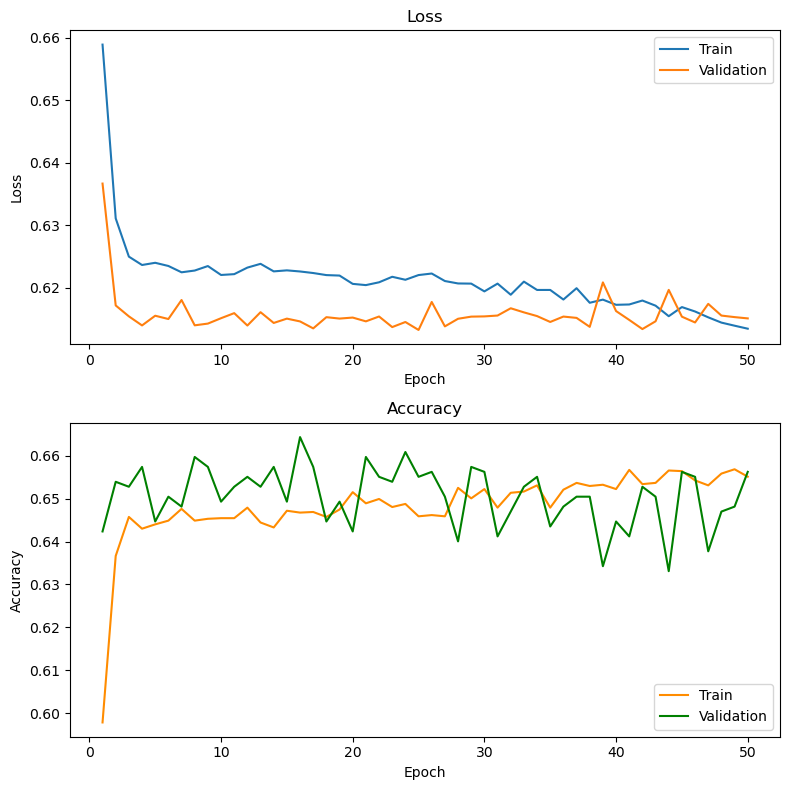

In [16]:
train_dataset, val_dataset, test_dataset = prepare_denom_model_data(df              = data_df,
                                                                    obs_id          = obs_id,
                                                                    obs_time        = obs_time,
                                                                    event           = event,
                                                                    outcome         = outcome,
                                                                    quan_fixed_covs = quan_fixed_covs,
                                                                    qual_fixed_covs = qual_fixed_covs,
                                                                    quan_vary_covs  = quan_vary_covs,
                                                                    qual_vary_covs  = qual_vary_covs,
                                                                    is_val_required = True
                                                                    )

bs     = 64
hd     = 128
lr     = 0.001
epochs = 50

seed  = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


treat_denom_model = LSTM4TreatmentExposureDenominatorModel(
                        longit_input_dim = train_dataset[0]["longitudinal"].shape[1],
                        static_input_dim = len(train_dataset[0]["static"]),
                        hidden_dim       = hd)

print(f"\nModel architecture:")
print(f"\n")
print(f"\n{treat_denom_model}")
print(f"\n")
print(f"\nModel training started...")
treat_denom_metrics = train_denom_model(model         = treat_denom_model,
                                        train_dataset = train_dataset,
                                        val_dataset   = val_dataset,
                                        lr            = lr,
                                        batch_size    = bs,
                                        epochs        = epochs
                                        )
print(f"\nModel training completed!")
plot_training_metrics(treat_denom_metrics)

### **Cross-Validation Denominator Model**

In [17]:
epochs = 50
param_grid = {
    'hidden_dim' : [16, 32, 64, 128],
    'lr'         : [0.01, 0.001, 0.0001],
    'batch_size' : [16, 32, 64, 128]
}
train_dataset, val_dataset, test_dataset = prepare_denom_model_data(df              = data_df,
                                                                    obs_id          = obs_id,
                                                                    obs_time        = obs_time,
                                                                    event           = event,
                                                                    outcome         = outcome,
                                                                    quan_fixed_covs = quan_fixed_covs,
                                                                    qual_fixed_covs = qual_fixed_covs,
                                                                    quan_vary_covs  = quan_vary_covs,
                                                                    qual_vary_covs  = qual_vary_covs,
                                                                    is_val_required = False
                                                                    )

best_params, best_summaries, best_loss = grid_search_denom_model(
                                         model_class = LSTM4TreatmentExposureDenominatorModel,
                                         dataset     = train_dataset,
                                         param_grid  = param_grid,
                                         epochs      = epochs,
                                         collate_fn  = collate_fn
)


     An 'is_eligible' variable is included to identify observations for modeling 'Treatment'.
     Of 24549 observations, 8649 are eligible.

     An 'is_eligible' variable is included to identify observations for modeling 'Treatment'.
     Of 24549 observations, 8649 are eligible.

     A dataframe containing only 8649 eligible observations for IPW model is extracted.
     Data to be split into sets of train 80.0% and test 20.0%.
     Spliting completed.
        Time-invariant features: ['X1', 'X2'].
            Quantitative features to be scaled:  ['X1']
            Standardized feature names:  ['X1_scaled']

            Qualitative features to be encoded:  ['X2']
            Encoded feature names:  ['X2_0', 'X2_1']

        Time-varying features: ['Obs_Time', 'Confounder1', 'Confounder2'].
            Quantitative features to be scaled:  ['Obs_Time', 'Confounder1']
            Standardized feature names:  ['Obs_Time_scaled', 'Confounder1_scaled']

            Qualitative features t

- data_alpha_0.2_gamma0.1_rho1_-0.1_rho2_-0.2_n5000_rep1
    Best Hyperparameters: {'batch_size': 32, 'hidden_dim': 32, 'lr': 0.0001}
     Lowest Validation Log Loss: 0.6261120973
      
- data_alpha_0.2_gamma0.1_rho1_-0.5_rho2_0.4_n5000_rep1
    -Best Hyperparameters: {'batch_size': 32, 'hidden_dim': 32, 'lr': 0.0001}
     Lowest Validation Log Loss: 0.6268178237 
      
- data_alpha_0.2_gamma0.1_rho1_0.9_rho2_0.7_n5000_rep1
    - epoch 30
    - Best Hyperparameters: {'batch_size': 64, 'hidden_dim': 128, 'lr': 0.0001}
     Lowest Validation Log Loss: 0.6227578874
    - 
      
- data_alpha_-0.5_gamma0.3_rho1_-0.1_rho2_-0.2_n5000_rep1
    - 
      Best Hyperparameters: {'batch_size': 64, 'hidden_dim': 128, 'lr': 0.0001}
     Lowest Validation Log Loss: 0.6255895916
- data_alpha_-0.5_gamma0.3_rho1_-0.5_rho2_0.4_n5000_rep1
    - 
      
- data_alpha_-0.5_gamma0.3_rho1_0.9_rho2_0.7_n5000_rep1
    - 

**Training denominator model with the optimal hyperparamters**


     An 'is_eligible' variable is included to identify observations for modeling 'Treatment'.
     Of 24549 observations, 8649 are eligible.

     An 'is_eligible' variable is included to identify observations for modeling 'Treatment'.
     Of 24549 observations, 8649 are eligible.

     A dataframe containing only 8649 eligible observations for IPW model is extracted.
     Data to be split into sets of train 80.0% and test 20.0%.
     Spliting completed.
        Time-invariant features: ['X1', 'X2'].
            Quantitative features to be scaled:  ['X1']
            Standardized feature names:  ['X1_scaled']

            Qualitative features to be encoded:  ['X2']
            Encoded feature names:  ['X2_0', 'X2_1']

        Time-varying features: ['Obs_Time', 'Confounder1', 'Confounder2'].
            Quantitative features to be scaled:  ['Obs_Time', 'Confounder1']
            Standardized feature names:  ['Obs_Time_scaled', 'Confounder1_scaled']

            Qualitative features t

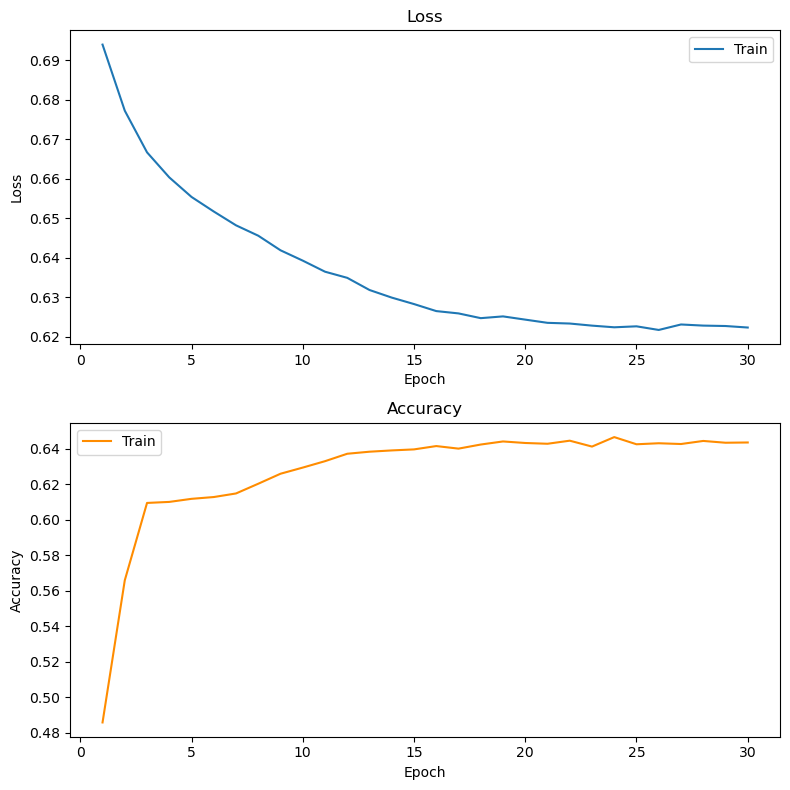

In [18]:
train_dataset, val_dataset, test_dataset = prepare_denom_model_data(df              = data_df,
                                                                    obs_id          = obs_id,
                                                                    obs_time        = obs_time,
                                                                    event           = event,
                                                                    outcome         = outcome,
                                                                    quan_fixed_covs = quan_fixed_covs,
                                                                    qual_fixed_covs = qual_fixed_covs,
                                                                    quan_vary_covs  = quan_vary_covs,
                                                                    qual_vary_covs  = qual_vary_covs,
                                                                    is_val_required = False
                                                                    )

bs = best_params['batch_size']
hd = best_params['hidden_dim']
lr = best_params['lr']
epochs = 30

seed  = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

treat_denom_model = LSTM4TreatmentExposureDenominatorModel(
                        longit_input_dim = train_dataset[0]["longitudinal"].shape[1],
                        static_input_dim = len(train_dataset[0]["static"]),
                        hidden_dim       = hd)

print(f"\nModel architecture:")
print(f"\n")
print(f"\n{treat_denom_model}")
print(f"\n")
print(f"\nModel training started...")
treat_denom_metrics = train_denom_model(model         = treat_denom_model,
                                        train_dataset = train_dataset,
                                        val_dataset   = val_dataset,
                                        lr            = lr,
                                        batch_size    = bs,
                                        epochs        = epochs
                                        )
print(f"\nModel training completed!")
plot_training_metrics(treat_denom_metrics)

**Numerator**


-----Preparing to extract baseline baseline variables ...

-----Extracting baseline variables completed!

     Data to be split into sets of train 80.0%, validation 10.0% and test 10.0%.
     Spliting completed.

-----Converting raw df to tensor datasets ...!


ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(), ['X2']),
                                ('StandardScaler', StandardScaler(), ['X1'])])


-----Tensor datasets obtained!
Epoch 1: Train Loss = 0.7045, Val Loss   = 0.6584 | Train Acc  = 0.5453, Val Acc    = 32.8120
Epoch 5: Train Loss = 0.6626, Val Loss   = 0.6384 | Train Acc  = 0.5992, Val Acc    = 32.5280
Epoch 10: Train Loss = 0.6637, Val Loss   = 0.6382 | Train Acc  = 0.5982, Val Acc    = 32.5280
Epoch 15: Train Loss = 0.6632, Val Loss   = 0.6378 | Train Acc  = 0.5985, Val Acc    = 32.5080
Epoch 20: Train Loss = 0.6629, Val Loss   = 0.6383 | Train Acc  = 0.5992, Val Acc    = 32.5280
Epoch 25: Train Loss = 0.6628, Val Loss   = 0.6385 | Train Acc  = 0.5998, Val Acc    = 32.5280
Epoch 30: Train Loss = 0.6628, Val Loss   = 0.6378 | Train Acc  = 0.5988, Val Acc    = 32.5280
Epoch 35: Train Loss = 0.6627, Val Loss   = 0.6389 | Train Acc  = 0.6005, Val Acc    = 32.5280
Epoch 40: Train Loss = 0.6626, Val Loss   = 0.6379 | Train Acc  = 0.6018, Val Acc    = 32.5280
Epoch 45: Train Loss = 0.6628, Val Loss   = 0.6385 | Train Acc  = 0.6002, Val Acc    = 32.5280
Epoch 50: Train Loss

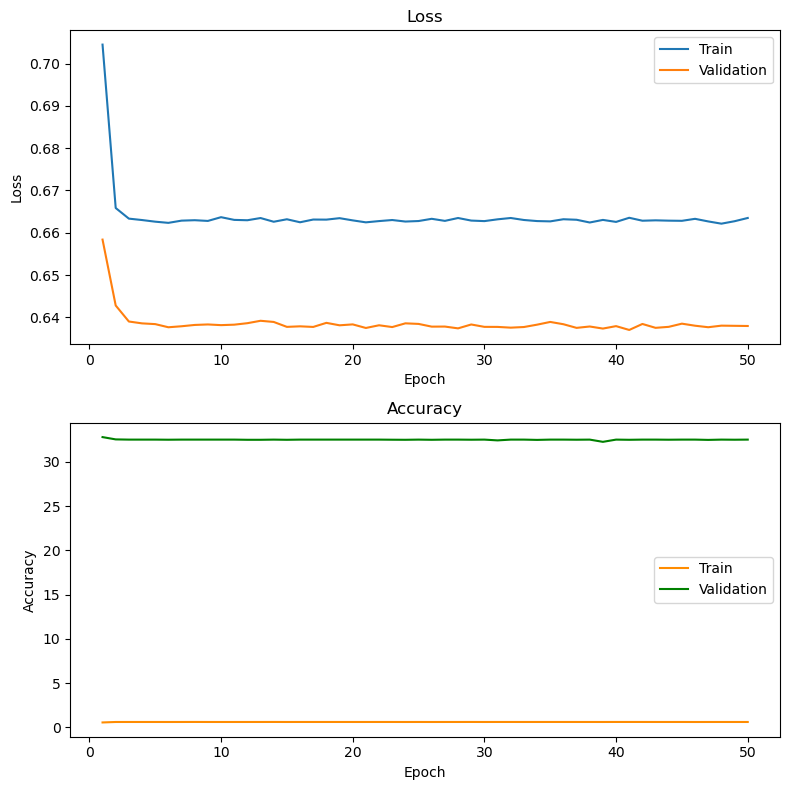

In [19]:
qual_covs = ["X2"]
quan_covs = ["X1"]

invariant_df = extract_baseline_vars(df        = data_df,
                                     obs_id    = obs_id,
                                     outcome   = outcome,
                                     qual_covs = qual_covs,
                                     quan_covs = quan_covs
                                     )

trn_raw_df, vld_raw_df, tst_raw_df = split_data(invariant_df, 
                                                obs_id          = obs_id, 
                                                outcome         = outcome,
                                                is_val_required = True
                                               )
train_ds, val_ds, test_ds = get_tensor_datasets(trn_raw_df, vld_raw_df, tst_raw_df, 
                                                qual_covs = qual_covs, quan_covs = quan_covs)

bs   = 64
hd   = 64
lr   = 0.01
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

treat_numer_model   = TreatmentExposureNumeratorModel(
                      input_dim  = len(list(train_ds)[0][0]), 
                      hidden_dim = hd
                    )

treat_numer_metrics = train_numer_model(treat_numer_model, 
                                        train_dataset      = train_ds, 
                                        val_dataset        = val_ds,
                                        batch_size         = bs,
                                        epochs             = 50, 
                                        lr                 = 0.01)
plot_training_metrics(treat_numer_metrics)

### **Cross-Validation Numerator Model**

In [20]:
param_grid = {
    "hidden_dim" : [16, 32, 64],
    "lr"         : [0.01, 0.001, 0.0001],
    "batch_size" : [16, 32, 64, 128]
}
epochs = 50

trn_raw_df, vld_raw_df, tst_raw_df = split_data(invariant_df, 
                                                obs_id          = obs_id, 
                                                outcome         = outcome,
                                                is_val_required = False
                                               )
train_ds, val_ds, test_ds = get_tensor_datasets(trn_raw_df, vld_raw_df, tst_raw_df, 
                                                qual_covs = qual_covs, quan_covs = quan_covs)

best_params, best_summary, best_val_loss = grid_search_cv_numer_model(
                                           model_class = TreatmentExposureNumeratorModel,
                                           dataset     = train_ds,
                                           param_grid  = param_grid,
                                           epochs      = epochs,
                                           n_splits    = 5
                                        )

     Data to be split into sets of train 80.0% and test 20.0%.
     Spliting completed.

-----Converting raw df to tensor datasets ...!


ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(), ['X2']),
                                ('StandardScaler', StandardScaler(), ['X1'])])


-----Tensor datasets obtained!

=== Testing hyperparameters: {'batch_size': 16, 'hidden_dim': 16, 'lr': 0.01} ===
  Fold 1/5
Epoch 1: Train Loss = 0.6838, Val Loss   = 0.6582 | Train Acc  = 0.5675, Val Acc    = 0.6062
Epoch 5: Train Loss = 0.6651, Val Loss   = 0.6580 | Train Acc  = 0.5969, Val Acc    = 0.6075
Epoch 10: Train Loss = 0.6646, Val Loss   = 0.6596 | Train Acc  = 0.5956, Val Acc    = 0.6250
Epoch 15: Train Loss = 0.6653, Val Loss   = 0.6568 | Train Acc  = 0.5944, Val Acc    = 0.6075
Epoch 20: Train Loss = 0.6654, Val Loss   = 0.6565 | Train Acc  = 0.5956, Val Acc    = 0.6088
Epoch 25: Train Loss = 0.6652, Val Loss   = 0.6570 | Train Acc  = 0.5934, Val Acc    = 0.6075
Epoch 30: Train Loss = 0.6652, Val Loss   = 0.6563 | Train Acc  = 0.5972, Val Acc    = 0.6112
Epoch 35: Train Loss = 0.6650, Val Loss   = 0.6568 | Train Acc  = 0.5969, Val Acc    = 0.6112
Epoch 40: Train Loss = 0.6650, Val Loss   = 0.6564 | Train Acc  = 0.5972, Val Acc    = 0.6075
Epoch 45: Train Loss = 0.6654,

- data_alpha_0.2_gamma0.1_rho1_-0.1_rho2_-0.2_n5000_rep1
    - 
      
- data_alpha_0.2_gamma0.1_rho1_-0.5_rho2_0.4_n5000_rep1
    -Best Hyperparameters: {'batch_size': 128, 'hidden_dim': 16, 'lr': 0.001}
   Lowest Validation Log Loss: 0.6636511820 
      
- data_alpha_0.2_gamma0.1_rho1_0.9_rho2_0.7_n5000_rep1
    - Best Hyperparameters: {'batch_size': 32, 'hidden_dim': 16, 'lr': 0.01}
   Lowest Validation Log Loss: 0.6661918564
      
- data_alpha_-0.5_gamma0.3_rho1_-0.1_rho2_-0.2_n5000_rep1
    - Best Hyperparameters: {'batch_size': 128, 'hidden_dim': 16, 'lr': 0.01}
   Lowest Validation Log Loss: 0.6583804454
      
- data_alpha_-0.5_gamma0.3_rho1_-0.5_rho2_0.4_n5000_rep1
    - 
      
- data_alpha_-0.5_gamma0.3_rho1_0.9_rho2_0.7_n5000_rep1
    - 

**Training numerator model with the optimal hyperparamters**

     Data to be split into sets of train 80.0% and test 20.0%.
     Spliting completed.

-----Converting raw df to tensor datasets ...!


ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(), ['X2']),
                                ('StandardScaler', StandardScaler(), ['X1'])])


-----Tensor datasets obtained!
     Data to be split into sets of train 80.0% and test 20.0%.
     Spliting completed.

-----Converting raw df to tensor datasets ...!


ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(), ['X2']),
                                ('StandardScaler', StandardScaler(), ['X1'])])


-----Tensor datasets obtained!
Epoch 1: Train Loss = 0.7293, Train Acc  = 0.5343
Epoch 10: Train Loss = 0.6622, Train Acc  = 0.5992
Epoch 20: Train Loss = 0.6632, Train Acc  = 0.5998
Epoch 30: Train Loss = 0.6627, Train Acc  = 0.5995
Epoch 40: Train Loss = 0.6627, Train Acc  = 0.5998
Epoch 50: Train Loss = 0.6637, Train Acc  = 0.5998


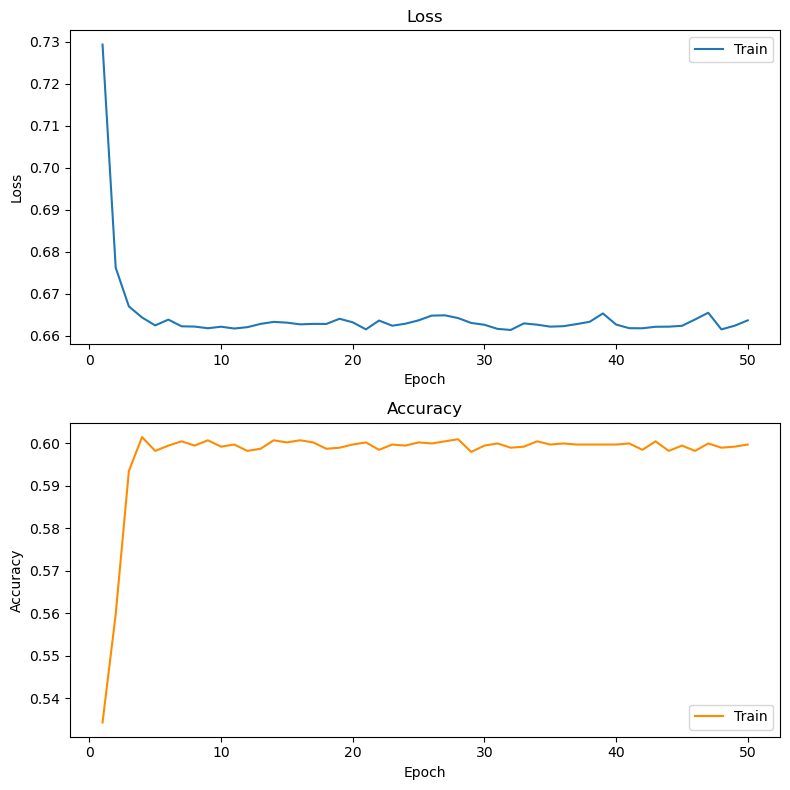

Test Loss: 0.6520
Test Accuracy: 0.6100


In [21]:
trn_raw_df, vld_raw_df, tst_raw_df = split_data(invariant_df, 
                                                obs_id          = obs_id, 
                                                outcome         = outcome,
                                                is_val_required = False
                                               )
train_ds, val_ds, test_ds = get_tensor_datasets(trn_raw_df, vld_raw_df, tst_raw_df, 
                                                qual_covs = qual_covs, quan_covs = quan_covs)


bs = best_params['batch_size']
hd = best_params['hidden_dim']
lr = best_params['lr']
epochs = 50

torch.manual_seed(seed)
np.random.seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

trn_raw_df, vld_raw_df, tst_raw_df = split_data(invariant_df, 
                                                obs_id          = obs_id, 
                                                outcome         = outcome,
                                                is_val_required = False
                                               )
train_ds, val_ds, test_ds = get_tensor_datasets(trn_raw_df, vld_raw_df, tst_raw_df, 
                                                qual_covs = qual_covs, quan_covs = quan_covs)

treat_numer_model   = TreatmentExposureNumeratorModel(
                      input_dim  = len(list(train_ds)[0][0]), 
                      hidden_dim = hd)

treat_numer_metrics = train_numer_model(model         = treat_numer_model, 
                                        train_dataset = train_ds, 
                                        val_dataset   = val_ds,
                                        batch_size    = bs,
                                        lr            = lr,
                                        epochs        = epochs
                                       )

plot_training_metrics(treat_numer_metrics)
pred_probs, pred_labels, _ = test_numer_model(treat_numer_model, 
                                              test_loader = DataLoader(test_ds, batch_size = bs))

### Saving Numerator and Denominator Quantities
A model is trained for one simulated dataset and then predictions are mode for all replicaitons

In [22]:
save_denom_IPWs(dir_path, treat_denom_model, treat_numer_model)

-----Data processing started...
        Time-invariant features: ['X1', 'X2'].
            Quantitative features to be scaled:  ['X1']
            Standardized feature names:  ['X1_scaled']

            Qualitative features to be encoded:  ['X2']
            Encoded feature names:  ['X2_0', 'X2_1']

        Time-varying features: ['Obs_Time', 'Confounder1', 'Confounder2'].
            Quantitative features to be scaled:  ['Obs_Time', 'Confounder1']
            Standardized feature names:  ['Obs_Time_scaled', 'Confounder1_scaled']

            Qualitative features to be encoded:  ['Confounder2']
OneHotEncoder(handle_unknown='ignore') ['Confounder2']
Index(['ID', 'X1', 'X2', 'Surv_Time', 'Obs_Time', 'Confounder1', 'Confounder2',
       'Treatment', 'Event', 'Obs_Time_scaled', 'Confounder1_scaled'],
      dtype='object')
            Encoded feature names:  ['Confounder2_0', 'Confounder2_1']
-----Data processing completed.

-----Converting data to longitudinal sequences ...

     Started p

In [1]:
import pandas as pd
%pip install lifelines -q
from lifelines import CoxTimeVaryingFitter

Note: you may need to restart the kernel to use updated packages.


$\alpha$, $\beta=-0.5$, $\gamma$

In [8]:
dir_path = "C://Users//A0087953//OneDrive - University of Witwatersrand//Desktop//@WitsSPH//Research_II_DL4CausalInference//DL4CI_Experiments//SimulatedData//n_1000//Six"
data_link = f"{dir_path}//data_alpha_-0.5_gamma0.3_rho1_0.9_rho2_0.7_n1000_rep1.csv"
data_df = pd.read_csv(data_link)
data_df["tstart"] = data_df["Obs_Time"] - 1
# display(data_df)
print("\nData Imported.")

event                      = "Event"
formula                    = "X2 + Treatment + (X2 * Treatment)"
obs_id                     = "ID"
obs_time                   = "Obs_Time"
start_time                 = "tstart"

unstabilized_treat_weights = "UnstabilizedIPTWs"
stabilized_treat_weights   = "StabilizedIPTWs"

data_df["tstart"] = data_df["Obs_Time"] - 1


Data Imported.


In [9]:
unweighted_treat_model = CoxTimeVaryingFitter()
unweighted_treat_model.fit(data_df,
                            id_col      = obs_id,
                            event_col   = event,
                            start_col   = start_time,
                            stop_col    = obs_time,
                            formula     = formula
                            )

unweighted_treat_model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
X2,-0.676906,0.508187,0.131362,-0.934371,-0.419442,0.392833,0.657414,0.0,-5.152994,2.563597e-07,21.895327
Treatment,-0.869967,0.418965,0.186952,-1.236387,-0.503548,0.290432,0.604383,0.0,-4.653424,3.264680e-06,18.224627
X2:Treatment,0.590113,1.804193,0.227275,0.144663,1.035564,1.155650,2.816694,0.0,2.596475,9.418563e-03,6.730277


In [10]:
unstabilized_treat_model = CoxTimeVaryingFitter()
unstabilized_treat_model.fit(data_df,
                            id_col      = obs_id,
                            event_col   = event,
                            start_col   = start_time,
                            stop_col    = obs_time,
                            formula     = formula,
                            weights_col = unstabilized_treat_weights,
                                )

unstabilized_treat_model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
X2,-0.676889,0.508196,0.069389,-0.812889,-0.540888,0.443575,0.582231,0.0,-9.754948,1.756914e-22,72.269375
Treatment,-0.520410,0.594277,0.088196,-0.693271,-0.347550,0.499938,0.706417,0.0,-5.900633,3.621088e-09,28.040930
X2:Treatment,0.693426,2.000558,0.107350,0.483024,0.903828,1.620969,2.469036,0.0,6.459495,1.050532e-10,33.148161


In [11]:
stabilized_treat_model = CoxTimeVaryingFitter()
stabilized_treat_model.fit(data_df,
                            id_col      = obs_id,
                            event_col   = event,
                            start_col   = start_time,
                            stop_col    = obs_time,
                            formula     = formula,
                            weights_col = stabilized_treat_weights,
                            )

stabilized_treat_model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
X2,-0.702455,0.495368,0.134884,-0.966824,-0.438086,0.380289,0.645270,0.0,-5.207828,1.910637e-07,22.319443
Treatment,-0.727389,0.483169,0.187191,-1.094277,-0.360501,0.334781,0.697327,0.0,-3.885806,1.019909e-04,13.259272
X2:Treatment,0.645644,1.907215,0.227371,0.200005,1.091283,1.221409,2.978092,0.0,2.839608,4.516907e-03,7.790449


In [12]:
results_dict = {
                "X2" : [],
                "LCIX2" : [],
                "UCIX2" : [],
                "pX2" : [],   

                "Treat" : [],
                "LCITreat" : [],
                "UCITreat" : [],
                "pTreat" : [],

                "X2Treat" : [],
                "LCIX2Treat" : [],
                "UCIX2Treat" : [],
                "pX2Treat" : [],


    
    
                "UnstabX2" : [],
                "LCIUnstabX2" : [],
                "UCIUnstabX2" : [],
                "pUnstabX2" : [],   

                "UnstabTreat" : [],
                "LCIUnstabTreat" : [],
                "UCIUnstabTreat" : [],
                "pUnstabTreat" : [],

                "UnstabX2Treat" : [],
                "LCIUnstabX2Treat" : [],
                "UCIUnstabX2Treat" : [],
                "pUnstabX2Treat" : [],


    
                "StabX2" : [],
                "LCIStabX2" : [],
                "UCIStabX2" : [],
                "pStabX2" : [],   

                "StabTreat" : [],
                "LCIStabTreat" : [],
                "UCIStabTreat" : [],
                "pStabTreat" : [],

                "StabX2Treat" : [],
                "LCIStabX2Treat" : [],
                "UCIStabX2Treat" : [],
                "pStabX2Treat" : [],
            }

results_dict["X2"].append(unweighted_treat_model.summary["coef"]["X2"])
results_dict["LCIX2"].append(unweighted_treat_model.summary["coef lower 95%"]["X2"])
results_dict["UCIX2"].append(unweighted_treat_model.summary["coef upper 95%"]["X2"])
results_dict["pX2"].append(unweighted_treat_model.summary["p"]["X2"])

results_dict["Treat"].append(unweighted_treat_model.summary["coef"]["Treatment"])
results_dict["LCITreat"].append(unweighted_treat_model.summary["coef lower 95%"]["Treatment"])
results_dict["UCITreat"].append(unweighted_treat_model.summary["coef upper 95%"]["Treatment"])
results_dict["pTreat"].append(unweighted_treat_model.summary["p"]["Treatment"])

results_dict["X2Treat"].append(unweighted_treat_model.summary["coef"]["X2:Treatment"])
results_dict["LCIX2Treat"].append(unweighted_treat_model.summary["coef lower 95%"]["X2:Treatment"])
results_dict["UCIX2Treat"].append(unweighted_treat_model.summary["coef upper 95%"]["X2:Treatment"])
results_dict["pX2Treat"].append(unweighted_treat_model.summary["p"]["X2:Treatment"])



results_dict["UnstabX2"].append(unstabilized_treat_model.summary["coef"]["X2"])
results_dict["LCIUnstabX2"].append(unstabilized_treat_model.summary["coef lower 95%"]["X2"])
results_dict["UCIUnstabX2"].append(unstabilized_treat_model.summary["coef upper 95%"]["X2"])
results_dict["pUnstabX2"].append(unstabilized_treat_model.summary["p"]["X2"])

results_dict["UnstabTreat"].append(unstabilized_treat_model.summary["coef"]["Treatment"])
results_dict["LCIUnstabTreat"].append(unstabilized_treat_model.summary["coef lower 95%"]["Treatment"])
results_dict["UCIUnstabTreat"].append(unstabilized_treat_model.summary["coef upper 95%"]["Treatment"])
results_dict["pUnstabTreat"].append(unstabilized_treat_model.summary["p"]["Treatment"])

results_dict["UnstabX2Treat"].append(unstabilized_treat_model.summary["coef"]["X2:Treatment"])
results_dict["LCIUnstabX2Treat"].append(unstabilized_treat_model.summary["coef lower 95%"]["X2:Treatment"])
results_dict["UCIUnstabX2Treat"].append(unstabilized_treat_model.summary["coef upper 95%"]["X2:Treatment"])
results_dict["pUnstabX2Treat"].append(unstabilized_treat_model.summary["p"]["X2:Treatment"])



results_dict["StabX2"].append(stabilized_treat_model.summary["coef"]["X2"])
results_dict["LCIStabX2"].append(stabilized_treat_model.summary["coef lower 95%"]["X2"])
results_dict["UCIStabX2"].append(stabilized_treat_model.summary["coef upper 95%"]["X2"])
results_dict["pStabX2"].append(stabilized_treat_model.summary["p"]["X2"])

results_dict["StabTreat"].append(stabilized_treat_model.summary["coef"]["Treatment"])
results_dict["LCIStabTreat"].append(stabilized_treat_model.summary["coef lower 95%"]["Treatment"])
results_dict["UCIStabTreat"].append(stabilized_treat_model.summary["coef upper 95%"]["Treatment"])
results_dict["pStabTreat"].append(stabilized_treat_model.summary["p"]["Treatment"])

results_dict["StabX2Treat"].append(stabilized_treat_model.summary["coef"]["X2:Treatment"])
results_dict["LCIStabX2Treat"].append(stabilized_treat_model.summary["coef lower 95%"]["X2:Treatment"])
results_dict["UCIStabX2Treat"].append(stabilized_treat_model.summary["coef upper 95%"]["X2:Treatment"])
results_dict["pStabX2Treat"].append(stabilized_treat_model.summary["p"]["X2:Treatment"])

In [13]:
pd.DataFrame(results_dict)

,X2,LCIX2,UCIX2,pX2,Treat,LCITreat,UCITreat,pTreat,X2Treat,LCIX2Treat,...,UCIStabX2,pStabX2,StabTreat,LCIStabTreat,UCIStabTreat,pStabTreat,StabX2Treat,LCIStabX2Treat,UCIStabX2Treat,pStabX2Treat
0,-0.676906,-0.934371,-0.419442,2.563597e-07,-0.869967,-1.236387,-0.503548,0.000003,0.590113,0.144663,...,-0.438086,1.910637e-07,-0.727389,-1.094277,-0.360501,0.000102,0.645644,0.200005,1.091283,0.004517


In [6]:
results_dict

{'StabX2': [-0.7024549751838388],
 'LCIStabX2': [-0.9668236148556115],
 'UCIStabX2': [-0.43808633551206616],
 'pStabX2': [1.9106371660145313e-07],
 'StabTreat': [-0.7273890672109627],
 'LCIStabTreat': [-1.0942772641880063],
 'UCIStabTreat': [-0.3605008702339192],
 'pStabTreat': [0.00010199091270256749],
 'StabX2Treat': [0.6456439901739737],
 'LCIStabX2Treat': [0.20000530258844768],
 'UCIStabX2Treat': [1.0912826777594997],
 'pStabX2Treat': [0.00451690704045223]}

In [15]:
import os

base_path = "C://Users//A0087953//OneDrive - University of Witwatersrand//Desktop//@WitsSPH//Research_II_DL4CausalInference//DL4CI_Experiments//SimulatedData//n_1000"  
num_folders = 0
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    num_folders += 1

    results_dict = {
                "X2" : [],
                "LCIX2" : [],
                "UCIX2" : [],
                "pX2" : [],   

                "Treat" : [],
                "LCITreat" : [],
                "UCITreat" : [],
                "pTreat" : [],

                "X2Treat" : [],
                "LCIX2Treat" : [],
                "UCIX2Treat" : [],
                "pX2Treat" : [],


    
    
                "UnstabX2" : [],
                "LCIUnstabX2" : [],
                "UCIUnstabX2" : [],
                "pUnstabX2" : [],   

                "UnstabTreat" : [],
                "LCIUnstabTreat" : [],
                "UCIUnstabTreat" : [],
                "pUnstabTreat" : [],

                "UnstabX2Treat" : [],
                "LCIUnstabX2Treat" : [],
                "UCIUnstabX2Treat" : [],
                "pUnstabX2Treat" : [],


    
                "StabX2" : [],
                "LCIStabX2" : [],
                "UCIStabX2" : [],
                "pStabX2" : [],   

                "StabTreat" : [],
                "LCIStabTreat" : [],
                "UCIStabTreat" : [],
                "pStabTreat" : [],

                "StabX2Treat" : [],
                "LCIStabX2Treat" : [],
                "UCIStabX2Treat" : [],
                "pStabX2Treat" : [],
            }
    
    num_files = 0
    saving_file = None
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path                 = os.path.join(folder_path, filename)
            if saving_file is None:
                saving_file = filename.rsplit('_', 1)[0]
                
            df                        = pd.read_csv(file_path)
            df["tstart"]               = df["Obs_Time"] - 1                
            event                      = "Event"
            formula                    = "X2 + Treatment + (X2 * Treatment)"
            obs_id                     = "ID"
            obs_time                   = "Obs_Time"
            start_time                 = "tstart"
            
            unstabilized_treat_weights = "UnstabilizedIPTWs"
            stabilized_treat_weights   = "StabilizedIPTWs"
            num_files += 1

            unweighted_treat_model = CoxTimeVaryingFitter()
            unweighted_treat_model.fit(df,
                                        id_col      = obs_id,
                                        event_col   = event,
                                        start_col   = start_time,
                                        stop_col    = obs_time,
                                        formula     = formula
                                        )

            unstabilized_treat_model = CoxTimeVaryingFitter()
            unstabilized_treat_model.fit(df,
                                        id_col      = obs_id,
                                        event_col   = event,
                                        start_col   = start_time,
                                        stop_col    = obs_time,
                                        formula     = formula,
                                        weights_col = unstabilized_treat_weights,
                                        )

            stabilized_treat_model = CoxTimeVaryingFitter()
            stabilized_treat_model.fit(df,
                                    id_col      = obs_id,
                                    event_col   = event,
                                    start_col   = start_time,
                                    stop_col    = obs_time,
                                    formula     = formula,
                                    weights_col = stabilized_treat_weights,
                                    )

            results_dict["X2"].append(unweighted_treat_model.summary["coef"]["X2"])
            results_dict["LCIX2"].append(unweighted_treat_model.summary["coef lower 95%"]["X2"])
            results_dict["UCIX2"].append(unweighted_treat_model.summary["coef upper 95%"]["X2"])
            results_dict["pX2"].append(unweighted_treat_model.summary["p"]["X2"])
            
            results_dict["Treat"].append(unweighted_treat_model.summary["coef"]["Treatment"])
            results_dict["LCITreat"].append(unweighted_treat_model.summary["coef lower 95%"]["Treatment"])
            results_dict["UCITreat"].append(unweighted_treat_model.summary["coef upper 95%"]["Treatment"])
            results_dict["pTreat"].append(unweighted_treat_model.summary["p"]["Treatment"])
            
            results_dict["X2Treat"].append(unweighted_treat_model.summary["coef"]["X2:Treatment"])
            results_dict["LCIX2Treat"].append(unweighted_treat_model.summary["coef lower 95%"]["X2:Treatment"])
            results_dict["UCIX2Treat"].append(unweighted_treat_model.summary["coef upper 95%"]["X2:Treatment"])
            results_dict["pX2Treat"].append(unweighted_treat_model.summary["p"]["X2:Treatment"])
            
            
            
            results_dict["UnstabX2"].append(unstabilized_treat_model.summary["coef"]["X2"])
            results_dict["LCIUnstabX2"].append(unstabilized_treat_model.summary["coef lower 95%"]["X2"])
            results_dict["UCIUnstabX2"].append(unstabilized_treat_model.summary["coef upper 95%"]["X2"])
            results_dict["pUnstabX2"].append(unstabilized_treat_model.summary["p"]["X2"])
            
            results_dict["UnstabTreat"].append(unstabilized_treat_model.summary["coef"]["Treatment"])
            results_dict["LCIUnstabTreat"].append(unstabilized_treat_model.summary["coef lower 95%"]["Treatment"])
            results_dict["UCIUnstabTreat"].append(unstabilized_treat_model.summary["coef upper 95%"]["Treatment"])
            results_dict["pUnstabTreat"].append(unstabilized_treat_model.summary["p"]["Treatment"])
            
            results_dict["UnstabX2Treat"].append(unstabilized_treat_model.summary["coef"]["X2:Treatment"])
            results_dict["LCIUnstabX2Treat"].append(unstabilized_treat_model.summary["coef lower 95%"]["X2:Treatment"])
            results_dict["UCIUnstabX2Treat"].append(unstabilized_treat_model.summary["coef upper 95%"]["X2:Treatment"])
            results_dict["pUnstabX2Treat"].append(unstabilized_treat_model.summary["p"]["X2:Treatment"])
            
            
            
            results_dict["StabX2"].append(stabilized_treat_model.summary["coef"]["X2"])
            results_dict["LCIStabX2"].append(stabilized_treat_model.summary["coef lower 95%"]["X2"])
            results_dict["UCIStabX2"].append(stabilized_treat_model.summary["coef upper 95%"]["X2"])
            results_dict["pStabX2"].append(stabilized_treat_model.summary["p"]["X2"])
            
            results_dict["StabTreat"].append(stabilized_treat_model.summary["coef"]["Treatment"])
            results_dict["LCIStabTreat"].append(stabilized_treat_model.summary["coef lower 95%"]["Treatment"])
            results_dict["UCIStabTreat"].append(stabilized_treat_model.summary["coef upper 95%"]["Treatment"])
            results_dict["pStabTreat"].append(stabilized_treat_model.summary["p"]["Treatment"])
            
            results_dict["StabX2Treat"].append(stabilized_treat_model.summary["coef"]["X2:Treatment"])
            results_dict["LCIStabX2Treat"].append(stabilized_treat_model.summary["coef lower 95%"]["X2:Treatment"])
            results_dict["UCIStabX2Treat"].append(stabilized_treat_model.summary["coef upper 95%"]["X2:Treatment"])
            results_dict["pStabX2Treat"].append(stabilized_treat_model.summary["p"]["X2:Treatment"])
    
    pd.DataFrame(results_dict).to_csv(f"{base_path}//{saving_file}.csv")
    print(f"{num_folders} In Folder '{folder}', number of files read are {num_files}.")

1 In Folder 'Five', number of files read are 500.
2 In Folder 'Four', number of files read are 500.
3 In Folder 'One', number of files read are 500.
4 In Folder 'Six', number of files read are 500.
5 In Folder 'Three', number of files read are 500.
6 In Folder 'Two', number of files read are 500.


In [1]:
import numpy as np
import os
import re
import pandas as pd

In [8]:
dir_path = "D://SimulatedData4CI//n_1000"

bias_var = {
    "parameters": [],
    
    "unweightedAlphaBias": [],
    "unweightedAlphaVar" : [],
    
    "unweightedBetaBias" : [],
    "unweightedBetaVar" : [],
    
    "unweightedGammaBias" : [],
    "unweightedGammaVar" : [],

    
    "unstabilizedAlphaBias" : [],
    "unstabilizedAlphaVar" : [],
    
    "unstabilizedBetaBias" : [],
    "unstabilizedBetaVar" : [],
    
    "unstabilizedGammaBias" : [],
    "unstabilizedGammaVar" : [],



    "stabilizedAlphaBias" : [],
    "stabilizedAlphaVar" : [],
    
    "stabilizedBetaBias" : [],
    "stabilizedBetaVar" : [],
    
    "stabilizedGammaBias" : [],
    "stabilizedGammaVar" : [], 
}

for filename in os.listdir(dir_path):
    beta  = -0.5

    if filename.endswith(".csv"):
        print("Filename: ", filename)
        alpha_match = re.search(r"alpha_(-?\d+\.?\d*)", filename)
        gamma_match = re.search(r"gamma(-?\d+\.?\d*)", filename)
        
        alpha = float(alpha_match.group(1)) if alpha_match else None
        gamma = float(gamma_match.group(1)) if gamma_match else None
        
        file_path = os.path.join(dir_path, filename)
        df        = pd.read_csv(file_path)

        bias_var["parameters"].append(f"{filename}")
        
        bias_var["unweightedAlphaBias"].append(np.mean(df["X2"]) - alpha)
        
        bias_var["unweightedAlphaVar"].append(np.var(df["X2"], ddof=1))
        
        bias_var["unweightedBetaBias"].append(np.mean(df["Treat"]) - beta)
        bias_var["unweightedBetaVar"].append(np.var(df["Treat"], ddof=1))
        
        bias_var["unweightedGammaBias"].append(np.mean(df["X2Treat"]) - gamma)
        bias_var["unweightedGammaVar"].append(np.var(df["X2Treat"], ddof=1))


        
        bias_var["unstabilizedAlphaBias"].append(np.mean(df["UnstabX2"]) - alpha)
        bias_var["unstabilizedAlphaVar"].append(np.var(df["UnstabX2"], ddof=1))
        
        bias_var["unstabilizedBetaBias"].append(np.mean(df["UnstabTreat"]) - beta)
        bias_var["unstabilizedBetaVar"].append(np.var(df["UnstabTreat"], ddof=1))
        
        bias_var["unstabilizedGammaBias"].append(np.mean(df["UnstabX2Treat"]) - gamma)
        bias_var["unstabilizedGammaVar"].append(np.var(df["UnstabX2Treat"], ddof=1))


        
        bias_var["stabilizedAlphaBias"].append(np.mean(df["StabX2"]) - alpha)
        bias_var["stabilizedAlphaVar"].append(np.var(df["StabX2"], ddof=1))
        
        bias_var["stabilizedBetaBias"].append(np.mean(df["StabTreat"]) - beta)
        bias_var["stabilizedBetaVar"].append(np.var(df["StabTreat"], ddof=1))
        
        bias_var["stabilizedGammaBias"].append(np.mean(df["StabX2Treat"]) - gamma)
        bias_var["stabilizedGammaVar"].append(np.var(df["StabX2Treat"], ddof=1))

pd.DataFrame(bias_var).to_csv(f"{dir_path}//BiasVarianceResults_{os.path.basename(dir_path)}.csv")

Filename:  data_alpha_-0.5_gamma0.3_rho1_-0.1_rho2_-0.2_n1000.csv
Filename:  data_alpha_-0.5_gamma0.3_rho1_-0.5_rho2_0.4_n1000.csv
Filename:  data_alpha_-0.5_gamma0.3_rho1_0.9_rho2_0.7_n1000.csv
Filename:  data_alpha_0.2_gamma0.1_rho1_-0.1_rho2_-0.2_n1000.csv
Filename:  data_alpha_0.2_gamma0.1_rho1_-0.5_rho2_0.4_n1000.csv
Filename:  data_alpha_0.2_gamma0.1_rho1_0.9_rho2_0.7_n1000.csv


In [7]:
pd.DataFrame(bias_var).to_csv(f"{dir_path}//BiasVarianceResults{os.path.basename(dir_path)}.csv")

In [25]:
# model_predictions = GetDenomModelPredictions()
# model_predictions.test_denom_model(treat_denom_model, 
#                                    data_loader = DataLoader(test_dataset, 
#                                                             batch_size    = 32, 
#                                                             shuffle       = False,
#                                                             collate_fn    = collate_fn
#                                                            )
#                                   )

# denom_treat_df = get_denom_model_summary(treat_denom_model,
#                                          data_df,
#                                          obs_id,
#                                          obs_time,
#                                          outcome,
#                                          outcome_type    = "exposure",
#                                          quan_fixed_covs = quan_fixed_covs,
#                                          quan_vary_covs  = quan_vary_covs,
#                                          qual_fixed_covs = qual_fixed_covs,
#                                          qual_vary_covs  = qual_vary_covs)

# weights_df = save_IPWs(survival_df  = data_df,
#                        ipw_df       = denom_treat_df,
#                        subj_id_col  = obs_id,
#                        time_id_col  = obs_time
#                        )
# weights_df

# treat_numer_df = get_numer_model_summary(treat_numer_model,
#                                          data_df,
#                                          obs_id              = obs_id,
#                                          obs_time            = obs_time,
#                                          outcome             = outcome,
#                                          outcome_type        = "exposure",
#                                          quan_covs           = quan_covs,
#                                          qual_covs           = qual_covs
#                                         )
# weights_df = save_IPWs(survival_df  = weights_df,
#                        ipw_df       = treat_numer_df,
#                        subj_id_col  = obs_id,
#                        time_id_col  = obs_time)
# weights_df["StabilizedIPTWs"] = weights_df["NumerTreatProbs"] / weights_df["DenomTreatProbs"]
# weights_df


# def save_denom_IPWs(dir_path : str, treat_denom_model : nn.Module, treat_numer_model : nn.Module):
#     num_files = 0
#     for filename in os.listdir(dir_path):
#         if filename.endswith(".csv"):
#             file_path      = os.path.join(dir_path, filename)
#             data_df        = pd.read_csv(file_path)
            
#             denom_treat_df = get_denom_model_summary(treat_denom_model,
#                                                      data_df,
#                                                      obs_id,
#                                                      obs_time,
#                                                      outcome,
#                                                      outcome_type        = "exposure",
#                                                      quan_fixed_covs     = quan_fixed_covs,
#                                                      quan_vary_covs      = quan_vary_covs,
#                                                      qual_fixed_covs     = qual_fixed_covs,
#                                                      qual_vary_covs      = qual_vary_covs
#                                                     )
            
#             weights_df = save_IPWs(survival_df  = data_df,
#                                    ipw_df       = denom_treat_df,
#                                    subj_id_col  = obs_id,
#                                    time_id_col  = obs_time
#                                    )
            
#             treat_numer_df = get_numer_model_summary(treat_numer_model,
#                                                      data_df,
#                                                      obs_id              = obs_id,
#                                                      obs_time            = obs_time,
#                                                      outcome             = outcome,
#                                                      outcome_type        = "exposure",
#                                                      quan_covs           = quan_covs,
#                                                      qual_covs           = qual_covs
#                                                     )
            
#             weights_df = save_IPWs(survival_df  = weights_df,
#                                    ipw_df       = treat_numer_df,
#                                    subj_id_col  = obs_id,
#                                    time_id_col  = obs_time)

#             weights_df["StabilizedIPTWs"] = weights_df["NumerTreatProbs"] / weights_df["DenomTreatProbs"]            
    
#             weights_df.to_csv(file_path, index = False)
            
#         num_files += 1  
            
#     print(f"Saving {num_files} files completed!")

Causal Models

In [ ]:
%pip install lifelines -q
from lifelines import CoxTimeVaryingFitter

In [ ]:
event                      = "death"
outcome                    = "haart_treat"
obs_id                     = "subject_id"
obs_time                   = "tend"
start_time                 = "tstart"
unstabilized_treat_weights = "UnstabilizedIPTWs"
stabilized_treat_weights   = "StabilizedIPTWs"

In [ ]:
unweighted_treat_model = CoxTimeVaryingFitter()
unweighted_treat_model.fit(weights_df,
                            id_col      = obs_id,
                            event_col   = event,
                            start_col   = start_time,
                            stop_col    = obs_time,
                            formula     = outcome
                            )

unweighted_treat_model.summary

In [ ]:
unstabilized_treat_model = CoxTimeVaryingFitter()
unstabilized_treat_model.fit(weights_df,
                                id_col      = obs_id,
                                event_col   = event,
                                start_col   = start_time,
                                stop_col    = obs_time,
                                weights_col = unstabilized_treat_weights,
                                formula     = outcome
                                )

unstabilized_treat_model.summary

In [ ]:
stabilized_treat_model = CoxTimeVaryingFitter()
stabilized_treat_model.fit(weights_df,
                            id_col      = obs_id,
                            event_col   = event,
                            start_col   = start_time,
                            stop_col    = obs_time,
                            weights_col = stabilized_treat_weights,
                            formula     = outcome
                            )

stabilized_treat_model.summary